# MFCC / speaker prediction / LSTM

In [91]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [92]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [93]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [94]:
gender_dict = {k:v for k,v in obj}

In [95]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data


def write_wav(file_path, fs, data):
    from scipy.io.wavfile import write
    try:
        write(file_path,fs, data)
        return 1
    except:
        return 0


- sampling rate = 16000 Hz
- 200,000点で，200,000/16,000  = 12.5 sec
- 50 msec くらいで切りたいので，
- 50*10^-3 * 16,000 = 800 点ずつ切ればいい？
- 2の累乗にすると1024くらい？(0.064 sec)

In [154]:
import pickle
with open("mfcc_lstm_data_4096.dump","rb") as f:
    (all_data, all_labels, all_speakers) = pickle.load(f,encoding="bytes")

In [156]:
all_data.shape

(15237, 4096)

In [ ]:
frame_length = 10000
stride = 2500

all_data = np.empty((0,frame_length), int)
all_labels = []
all_speakers = []

cnt = 0
for path in glob.glob("wav_samples/*"):
    fs,data = load_wav(path)
    print(cnt,path)
    
    frame_num = int((data.shape[0]-frame_length)/stride) 
    for i in range(frame_num):
        all_data = np.append(all_data, np.array([data[i*stride:i*stride+frame_length]]), axis=0)

    label = gender_dict[int(path.split("/")[1].split("-")[0])]
    all_labels.extend([label]*frame_num)
    all_speakers.extend([cnt]*frame_num)
    
    cnt += 1
#     if cnt > 80:
#         break
    
print(all_data.shape)
all_labels = np.array(all_labels)

0 wav_samples/103-1240-0000.flac.wav
1 wav_samples/1034-121119-0000.flac.wav
2 wav_samples/1040-133433-0000.flac.wav
3 wav_samples/1069-133699-0000.flac.wav
4 wav_samples/1081-125237-0000.flac.wav
5 wav_samples/1088-129236-0000.flac.wav
6 wav_samples/1098-133695-0000.flac.wav
7 wav_samples/1116-132847-0000.flac.wav
8 wav_samples/118-121721-0000.flac.wav
9 wav_samples/1183-124566-0000.flac.wav
10 wav_samples/1235-135883-0000.flac.wav
11 wav_samples/1246-124548-0000.flac.wav
12 wav_samples/125-121124-0000.flac.wav
13 wav_samples/1263-138246-0000.flac.wav
14 wav_samples/1334-135589-0000.flac.wav
15 wav_samples/1355-39947-0000.flac.wav
16 wav_samples/1363-135842-0000.flac.wav
17 wav_samples/1447-130550-0000.flac.wav
18 wav_samples/1455-134435-0000.flac.wav
19 wav_samples/150-126107-0000.flac.wav
20 wav_samples/1502-122615-0000.flac.wav
21 wav_samples/1553-140047-0000.flac.wav
22 wav_samples/1578-140045-0000.flac.wav
23 wav_samples/1594-135914-0000.flac.wav
24 wav_samples/1624-142933-0000.f

In [208]:
# import pickle
# with open("mfcc_lstm_data_10000.dump","wb") as f:
#     pickle.dump((all_data, all_labels, all_speakers),f)

In [157]:
print(all_data.shape)
print(all_labels.shape)
# print(all_speakers.shape)

(15237, 4096)
(15237,)


In [158]:
def dens_threshold(data, th, win=100):
    # 閾値
    L = len(data)
    abs_sum = []
    for i in range(int(L/100)):
        d = data[i*100:(i+1)*100]
        abs_sum.append(np.sum(np.array([np.abs(x) for x in d]))//100.)

    pos = 0; neg = 0
    for i in abs_sum:
        if i >= 800.:
            pos += 1
        else:
            neg += 1
#     print("pos:",pos,"neg:",neg,"/",int(L/100))
    if pos/int(L/100) > 0.5:
        return 1
    else:
        return 0

In [159]:
%%time

all_data_label_speaker = np.array([(x,y,z) for x,y,z in zip(all_data,all_labels,all_speakers) if dens_threshold(x, 800)])

all_data = np.array([x for x,y,z in all_data_label_speaker])
all_labels = np.array([y for x,y,z in all_data_label_speaker])
all_speakers = np.array([z for x,y,z in all_data_label_speaker])

CPU times: user 1min 3s, sys: 575 ms, total: 1min 4s
Wall time: 1min 8s


In [161]:
all_data.shape

(5591, 4096)

In [162]:
import random
# Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
indices = np.arange(len(all_data))
np.random.shuffle(indices)
all_data = all_data[indices]
all_labels = all_labels[indices]
all_speakers = all_speakers

In [163]:
x_train = all_data[:5200]
y_train = all_labels[:5200]
x_test = all_data[5200:]
y_test = all_labels[5200:]
s_train = all_speakers[:5200]
s_test = all_speakers[5200:]

In [205]:
path ="./wav_samples/103-1240-0000.flac.wav"
fs,data = load_wav(path)
write_wav("test.wav",fs,data[:20000])

1

[7.0, 6.0, 6.0, 6.0, 5.0, 6.0, 9.0, 7.0, 5.0, 7.0, 822.0, 1725.0, 1375.0, 440.0, 1083.0, 2280.0, 1721.0, 1415.0, 2140.0, 2263.0, 2545.0, 2591.0, 2494.0, 2448.0, 2356.0, 2318.0, 2241.0, 2094.0, 1569.0, 1119.0, 1055.0, 920.0, 795.0, 815.0, 1074.0, 1505.0, 1777.0, 2038.0, 1536.0, 1507.0, 1497.0, 1604.0, 1529.0, 1606.0, 1496.0, 1231.0, 1127.0, 1007.0, 951.0, 841.0, 643.0, 517.0, 487.0, 713.0, 936.0, 1156.0, 795.0, 762.0, 817.0, 988.0, 853.0, 803.0, 609.0, 753.0, 743.0, 699.0, 693.0, 522.0, 215.0, 499.0, 1508.0, 1414.0, 1168.0, 1502.0, 1586.0, 1816.0, 1620.0, 1527.0, 1198.0, 1620.0, 1625.0, 1669.0, 1298.0, 1250.0, 1356.0, 1365.0, 1478.0, 1077.0, 1113.0, 865.0, 1209.0, 1114.0, 867.0, 902.0, 855.0, 896.0, 643.0, 604.0, 673.0, 631.0]
pos: 86 neg: 14 / 100
mean: 46310.2732106 std: 82428.8138274 mean/std: 0.561821419723
3613.53297883 1507038.53389 0.00239777079189
max-val: 1507038.53389 max-freq: 180.8 max/std: 18.2829093847
mfcc shape (20, 6)


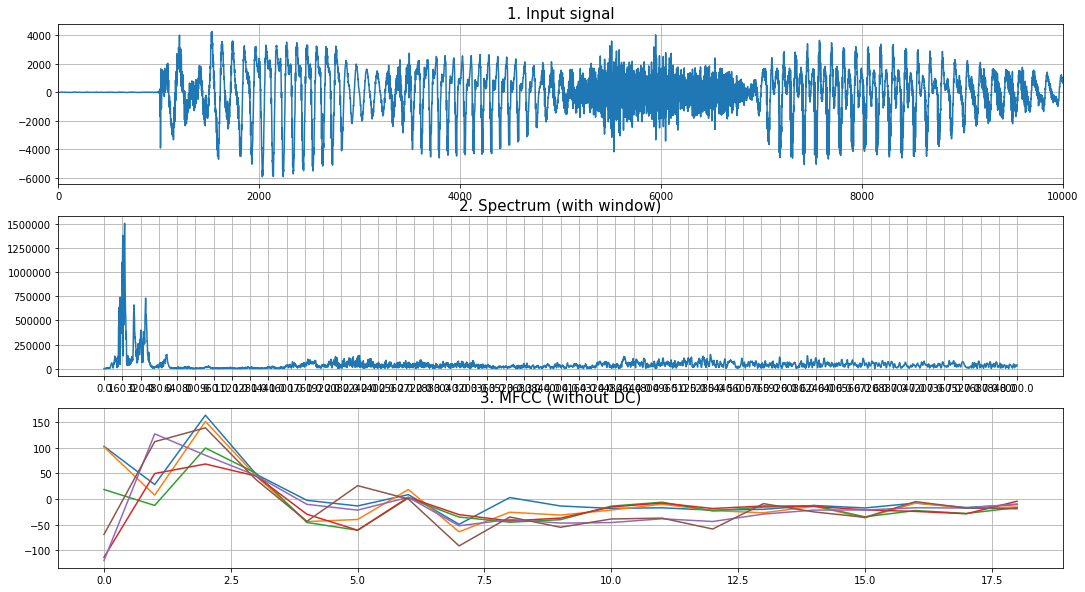

[2318.0, 2241.0, 2094.0, 1569.0, 1119.0, 1055.0, 920.0, 795.0, 815.0, 1074.0, 1505.0, 1777.0, 2038.0, 1536.0, 1507.0, 1497.0, 1604.0, 1529.0, 1606.0, 1496.0, 1231.0, 1127.0, 1007.0, 951.0, 841.0, 643.0, 517.0, 487.0, 713.0, 936.0, 1156.0, 795.0, 762.0, 817.0, 988.0, 853.0, 803.0, 609.0, 753.0, 743.0, 699.0, 693.0, 522.0, 215.0, 499.0, 1508.0, 1414.0, 1168.0, 1502.0, 1586.0, 1816.0, 1620.0, 1527.0, 1198.0, 1620.0, 1625.0, 1669.0, 1298.0, 1250.0, 1356.0, 1365.0, 1478.0, 1077.0, 1113.0, 865.0, 1209.0, 1114.0, 867.0, 902.0, 855.0, 896.0, 643.0, 604.0, 673.0, 631.0, 315.0, 326.0, 216.0, 144.0, 171.0, 101.0, 141.0, 137.0, 125.0, 218.0, 185.0, 282.0, 693.0, 202.0, 1243.0, 1104.0, 753.0, 1466.0, 1001.0, 850.0, 1465.0, 650.0, 1292.0, 1192.0, 662.0]
pos: 84 neg: 16 / 100
mean: 42267.1915671 std: 78359.6563244 mean/std: 0.539399909975
3772.83525596 1581431.931 0.00238570828247
max-val: 1581431.931 max-freq: 262.4 max/std: 20.1817109107
mfcc shape (20, 6)


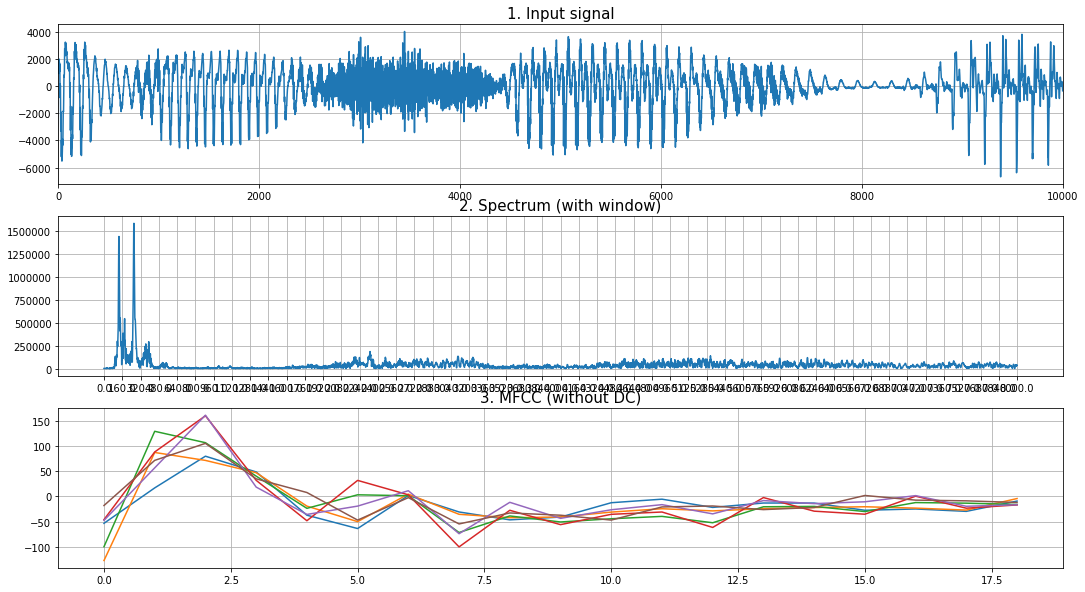

[218.0, 200.0, 385.0, 329.0, 293.0, 281.0, 160.0, 572.0, 324.0, 300.0, 165.0, 363.0, 426.0, 471.0, 91.0, 340.0, 526.0, 500.0, 203.0, 385.0, 425.0, 426.0, 478.0, 782.0, 887.0, 966.0, 1135.0, 935.0, 737.0, 846.0, 920.0, 999.0, 1403.0, 1419.0, 1361.0, 1215.0, 1443.0, 1185.0, 1332.0, 1249.0, 1088.0, 958.0, 764.0, 603.0, 431.0, 233.0, 1183.0, 2354.0, 2342.0, 3023.0, 3274.0, 3523.0, 3271.0, 2360.0, 3042.0, 2954.0, 3122.0, 2520.0, 1547.0, 2081.0, 1441.0, 599.0, 388.0, 719.0, 526.0, 570.0, 784.0, 985.0, 738.0, 898.0, 954.0, 1035.0, 857.0, 1046.0, 1168.0, 1130.0, 1233.0, 2358.0, 2166.0, 2138.0, 2720.0, 1568.0, 1101.0, 1381.0, 1333.0, 1863.0, 1613.0, 1246.0, 1292.0, 1451.0, 1344.0, 923.0, 922.0, 889.0, 924.0, 2724.0, 3935.0, 4552.0, 4057.0, 4253.0]
pos: 77 neg: 23 / 100
mean: 60004.7608104 std: 119694.65473 mean/std: 0.501315292198
572589.355747 1990625.01456 0.287643002354
max-val: 1990625.01456 max-freq: 259.2 max/std: 16.630859741
mfcc shape (20, 6)


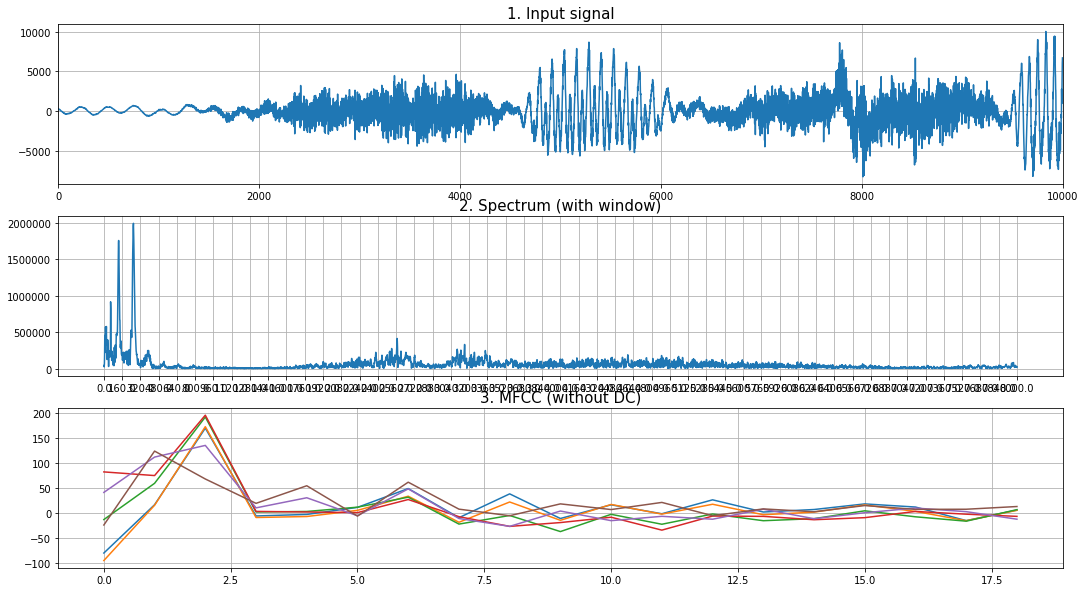

[966.0, 1135.0, 935.0, 737.0, 846.0, 920.0, 999.0, 1403.0, 1419.0, 1361.0, 1215.0, 1443.0, 1185.0, 1332.0, 1249.0, 1088.0, 958.0, 764.0, 603.0, 431.0, 233.0, 1183.0, 2354.0, 2342.0, 3023.0, 3274.0, 3523.0, 3271.0, 2360.0, 3042.0, 2954.0, 3122.0, 2520.0, 1547.0, 2081.0, 1441.0, 599.0, 388.0, 719.0, 526.0, 570.0, 784.0, 985.0, 738.0, 898.0, 954.0, 1035.0, 857.0, 1046.0, 1168.0, 1130.0, 1233.0, 2358.0, 2166.0, 2138.0, 2720.0, 1568.0, 1101.0, 1381.0, 1333.0, 1863.0, 1613.0, 1246.0, 1292.0, 1451.0, 1344.0, 923.0, 922.0, 889.0, 924.0, 2724.0, 3935.0, 4552.0, 4057.0, 4253.0, 4629.0, 3580.0, 3862.0, 3480.0, 3399.0, 3561.0, 4121.0, 3676.0, 4101.0, 4194.0, 2580.0, 3165.0, 1963.0, 1477.0, 1572.0, 1282.0, 1600.0, 1285.0, 1357.0, 1579.0, 632.0, 461.0, 440.0, 602.0, 479.0]
pos: 94 neg: 6 / 100
mean: 76786.7235355 std: 123735.194164 mean/std: 0.620573023338
984275.949014 1493169.95918 0.659185475143
max-val: 1493169.95918 max-freq: 257.6 max/std: 12.0674636612
mfcc shape (20, 6)


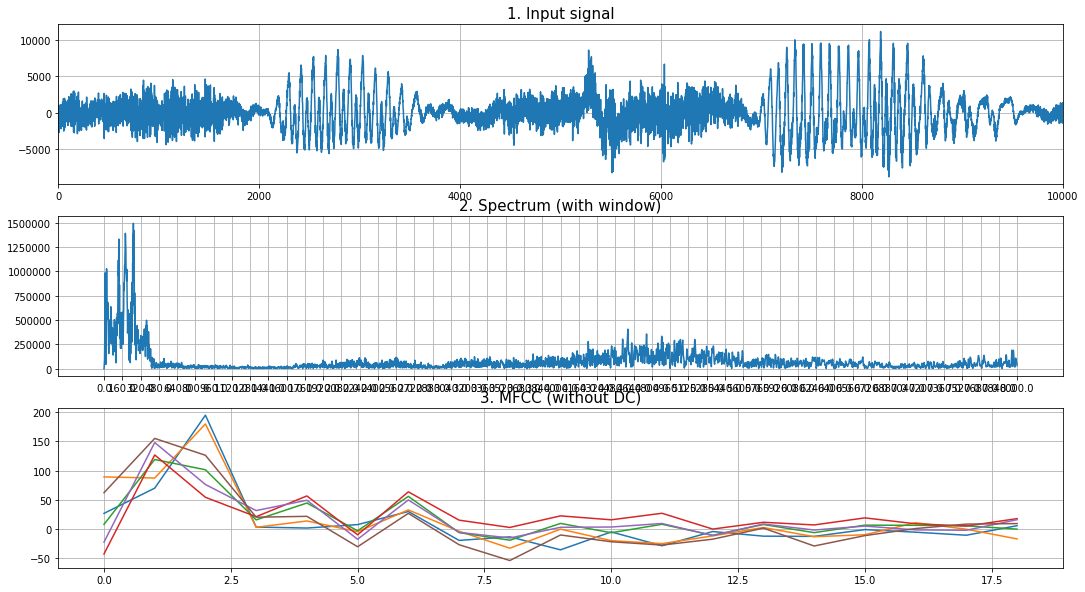

[3274.0, 3523.0, 3271.0, 2360.0, 3042.0, 2954.0, 3122.0, 2520.0, 1547.0, 2081.0, 1441.0, 599.0, 388.0, 719.0, 526.0, 570.0, 784.0, 985.0, 738.0, 898.0, 954.0, 1035.0, 857.0, 1046.0, 1168.0, 1130.0, 1233.0, 2358.0, 2166.0, 2138.0, 2720.0, 1568.0, 1101.0, 1381.0, 1333.0, 1863.0, 1613.0, 1246.0, 1292.0, 1451.0, 1344.0, 923.0, 922.0, 889.0, 924.0, 2724.0, 3935.0, 4552.0, 4057.0, 4253.0, 4629.0, 3580.0, 3862.0, 3480.0, 3399.0, 3561.0, 4121.0, 3676.0, 4101.0, 4194.0, 2580.0, 3165.0, 1963.0, 1477.0, 1572.0, 1282.0, 1600.0, 1285.0, 1357.0, 1579.0, 632.0, 461.0, 440.0, 602.0, 479.0, 759.0, 783.0, 842.0, 1018.0, 1164.0, 1216.0, 1372.0, 1420.0, 934.0, 1232.0, 1260.0, 1115.0, 892.0, 1202.0, 1388.0, 1508.0, 1572.0, 2078.0, 1451.0, 1590.0, 1231.0, 1097.0, 1186.0, 1285.0, 1253.0]
pos: 96 neg: 4 / 100
mean: 84068.0673424 std: 176653.35658 mean/std: 0.475892838779
911857.60958 2601501.72063 0.35051201479
max-val: 2601501.72063 max-freq: 187.2 max/std: 14.7265909406
mfcc shape (20, 6)


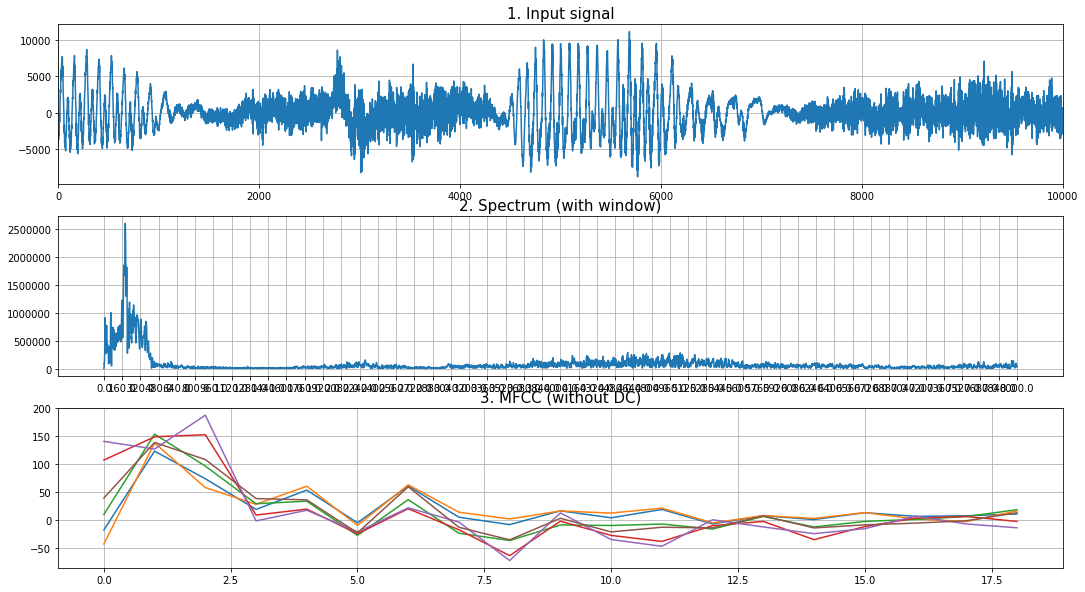

[1130.0, 1233.0, 2358.0, 2166.0, 2138.0, 2720.0, 1568.0, 1101.0, 1381.0, 1333.0, 1863.0, 1613.0, 1246.0, 1292.0, 1451.0, 1344.0, 923.0, 922.0, 889.0, 924.0, 2724.0, 3935.0, 4552.0, 4057.0, 4253.0, 4629.0, 3580.0, 3862.0, 3480.0, 3399.0, 3561.0, 4121.0, 3676.0, 4101.0, 4194.0, 2580.0, 3165.0, 1963.0, 1477.0, 1572.0, 1282.0, 1600.0, 1285.0, 1357.0, 1579.0, 632.0, 461.0, 440.0, 602.0, 479.0, 759.0, 783.0, 842.0, 1018.0, 1164.0, 1216.0, 1372.0, 1420.0, 934.0, 1232.0, 1260.0, 1115.0, 892.0, 1202.0, 1388.0, 1508.0, 1572.0, 2078.0, 1451.0, 1590.0, 1231.0, 1097.0, 1186.0, 1285.0, 1253.0, 1094.0, 1336.0, 1159.0, 1005.0, 627.0, 261.0, 338.0, 271.0, 237.0, 464.0, 196.0, 201.0, 315.0, 372.0, 213.0, 240.0, 562.0, 420.0, 488.0, 706.0, 450.0, 591.0, 541.0, 413.0, 796.0]
pos: 82 neg: 18 / 100
mean: 72891.9864754 std: 123806.772218 mean/std: 0.588756052433
464641.365012 1498518.98602 0.310067052434
max-val: 1498518.98602 max-freq: 187.2 max/std: 12.1036915766
mfcc shape (20, 6)


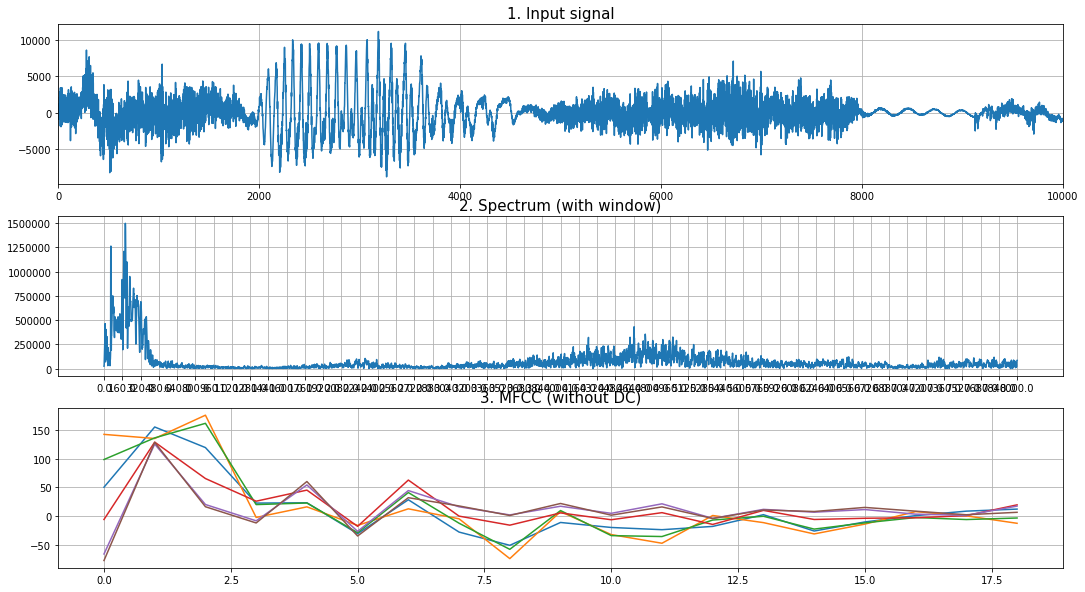

[384.0, 534.0, 495.0, 667.0, 247.0, 254.0, 184.0, 229.0, 543.0, 311.0, 228.0, 173.0, 315.0, 303.0, 257.0, 290.0, 323.0, 287.0, 248.0, 303.0, 400.0, 207.0, 231.0, 303.0, 397.0, 311.0, 229.0, 248.0, 467.0, 245.0, 234.0, 290.0, 399.0, 278.0, 227.0, 373.0, 158.0, 401.0, 278.0, 385.0, 211.0, 396.0, 256.0, 458.0, 520.0, 405.0, 302.0, 282.0, 1156.0, 2419.0, 1847.0, 2957.0, 1420.0, 917.0, 1453.0, 1513.0, 1374.0, 1476.0, 1096.0, 1827.0, 2024.0, 1433.0, 2483.0, 2067.0, 1903.0, 2709.0, 2259.0, 2326.0, 2974.0, 2130.0, 2573.0, 3251.0, 1990.0, 2710.0, 3101.0, 1589.0, 2254.0, 2280.0, 1531.0, 1271.0, 965.0, 1022.0, 1279.0, 1258.0, 1518.0, 1279.0, 1174.0, 1293.0, 879.0, 1324.0, 1603.0, 1879.0, 1935.0, 1774.0, 2898.0, 2272.0, 2627.0, 3073.0, 1955.0, 2329.0]
pos: 56 neg: 44 / 100
mean: 28190.6598354 std: 106774.514455 mean/std: 0.264020491963
305218.199537 2895922.64508 0.105395839925
max-val: 2895922.64508 max-freq: 104.0 max/std: 27.1218526244
mfcc shape (20, 6)


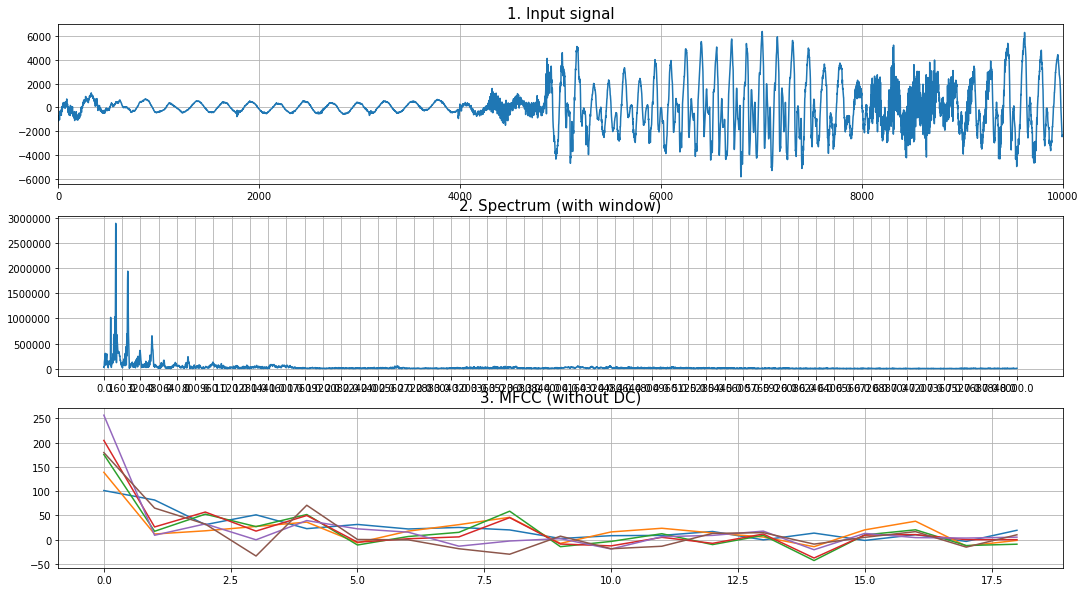

[311.0, 229.0, 248.0, 467.0, 245.0, 234.0, 290.0, 399.0, 278.0, 227.0, 373.0, 158.0, 401.0, 278.0, 385.0, 211.0, 396.0, 256.0, 458.0, 520.0, 405.0, 302.0, 282.0, 1156.0, 2419.0, 1847.0, 2957.0, 1420.0, 917.0, 1453.0, 1513.0, 1374.0, 1476.0, 1096.0, 1827.0, 2024.0, 1433.0, 2483.0, 2067.0, 1903.0, 2709.0, 2259.0, 2326.0, 2974.0, 2130.0, 2573.0, 3251.0, 1990.0, 2710.0, 3101.0, 1589.0, 2254.0, 2280.0, 1531.0, 1271.0, 965.0, 1022.0, 1279.0, 1258.0, 1518.0, 1279.0, 1174.0, 1293.0, 879.0, 1324.0, 1603.0, 1879.0, 1935.0, 1774.0, 2898.0, 2272.0, 2627.0, 3073.0, 1955.0, 2329.0, 1448.0, 845.0, 602.0, 502.0, 360.0, 684.0, 500.0, 846.0, 356.0, 461.0, 198.0, 508.0, 158.0, 696.0, 1309.0, 2735.0, 4910.0, 3826.0, 5277.0, 4667.0, 4934.0, 5008.0, 4347.0, 5537.0, 4993.0]
pos: 73 neg: 27 / 100
mean: 45045.7686466 std: 135951.187141 mean/std: 0.331337810237
298388.301936 3346339.26829 0.0891685743773
max-val: 3346339.26829 max-freq: 104.0 max/std: 24.6142703028
mfcc shape (20, 6)


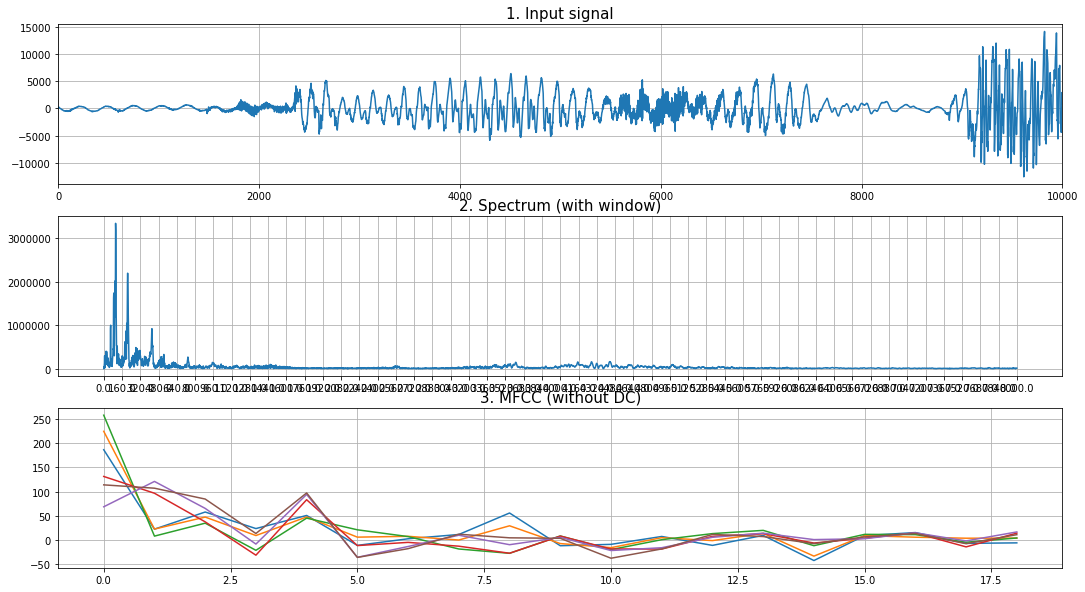

[1847.0, 2957.0, 1420.0, 917.0, 1453.0, 1513.0, 1374.0, 1476.0, 1096.0, 1827.0, 2024.0, 1433.0, 2483.0, 2067.0, 1903.0, 2709.0, 2259.0, 2326.0, 2974.0, 2130.0, 2573.0, 3251.0, 1990.0, 2710.0, 3101.0, 1589.0, 2254.0, 2280.0, 1531.0, 1271.0, 965.0, 1022.0, 1279.0, 1258.0, 1518.0, 1279.0, 1174.0, 1293.0, 879.0, 1324.0, 1603.0, 1879.0, 1935.0, 1774.0, 2898.0, 2272.0, 2627.0, 3073.0, 1955.0, 2329.0, 1448.0, 845.0, 602.0, 502.0, 360.0, 684.0, 500.0, 846.0, 356.0, 461.0, 198.0, 508.0, 158.0, 696.0, 1309.0, 2735.0, 4910.0, 3826.0, 5277.0, 4667.0, 4934.0, 5008.0, 4347.0, 5537.0, 4993.0, 3999.0, 3496.0, 4610.0, 3965.0, 3741.0, 3178.0, 2837.0, 3021.0, 2494.0, 1726.0, 1280.0, 239.0, 226.0, 476.0, 495.0, 284.0, 123.0, 349.0, 561.0, 157.0, 310.0, 271.0, 454.0, 191.0, 231.0]
pos: 82 neg: 18 / 100
mean: 65766.7637804 std: 155685.269086 mean/std: 0.42243408234
480408.763498 2134178.52258 0.225102426257
max-val: 2134178.52258 max-freq: 88.0 max/std: 13.7082881065
mfcc shape (20, 6)


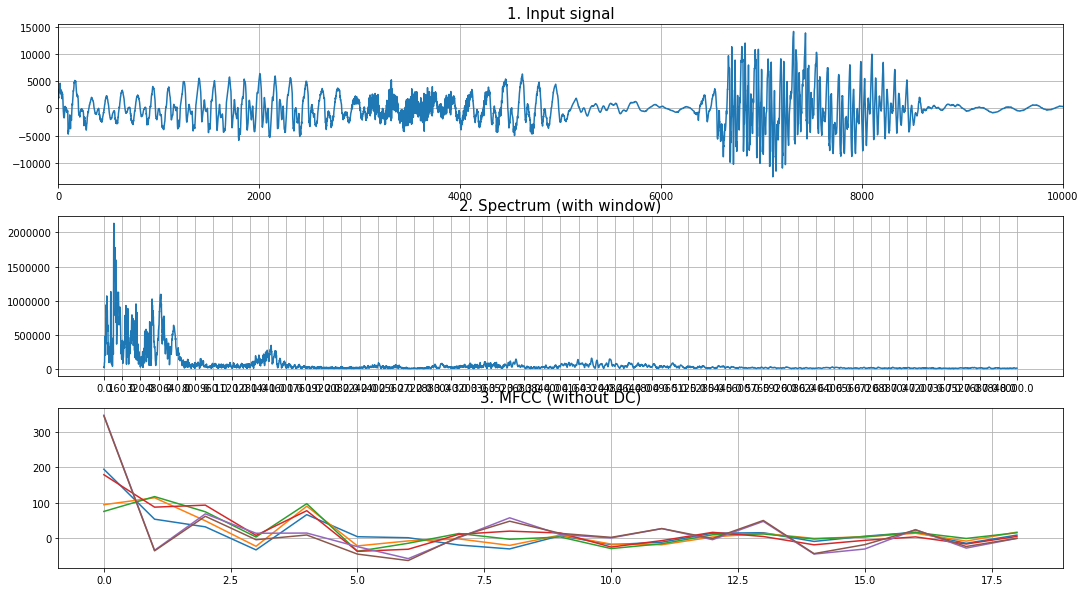

[1589.0, 2254.0, 2280.0, 1531.0, 1271.0, 965.0, 1022.0, 1279.0, 1258.0, 1518.0, 1279.0, 1174.0, 1293.0, 879.0, 1324.0, 1603.0, 1879.0, 1935.0, 1774.0, 2898.0, 2272.0, 2627.0, 3073.0, 1955.0, 2329.0, 1448.0, 845.0, 602.0, 502.0, 360.0, 684.0, 500.0, 846.0, 356.0, 461.0, 198.0, 508.0, 158.0, 696.0, 1309.0, 2735.0, 4910.0, 3826.0, 5277.0, 4667.0, 4934.0, 5008.0, 4347.0, 5537.0, 4993.0, 3999.0, 3496.0, 4610.0, 3965.0, 3741.0, 3178.0, 2837.0, 3021.0, 2494.0, 1726.0, 1280.0, 239.0, 226.0, 476.0, 495.0, 284.0, 123.0, 349.0, 561.0, 157.0, 310.0, 271.0, 454.0, 191.0, 231.0, 280.0, 399.0, 279.0, 973.0, 879.0, 1249.0, 1171.0, 1777.0, 2007.0, 1814.0, 2452.0, 1076.0, 1110.0, 511.0, 733.0, 417.0, 251.0, 297.0, 374.0, 274.0, 222.0, 206.0, 442.0, 325.0, 282.0]
pos: 69 neg: 31 / 100
mean: 74179.8317166 std: 207099.990106 mean/std: 0.358183656497
734286.093435 1821066.75666 0.40321755957
max-val: 1821066.75666 max-freq: 424.0 max/std: 8.79317645419
mfcc shape (20, 6)


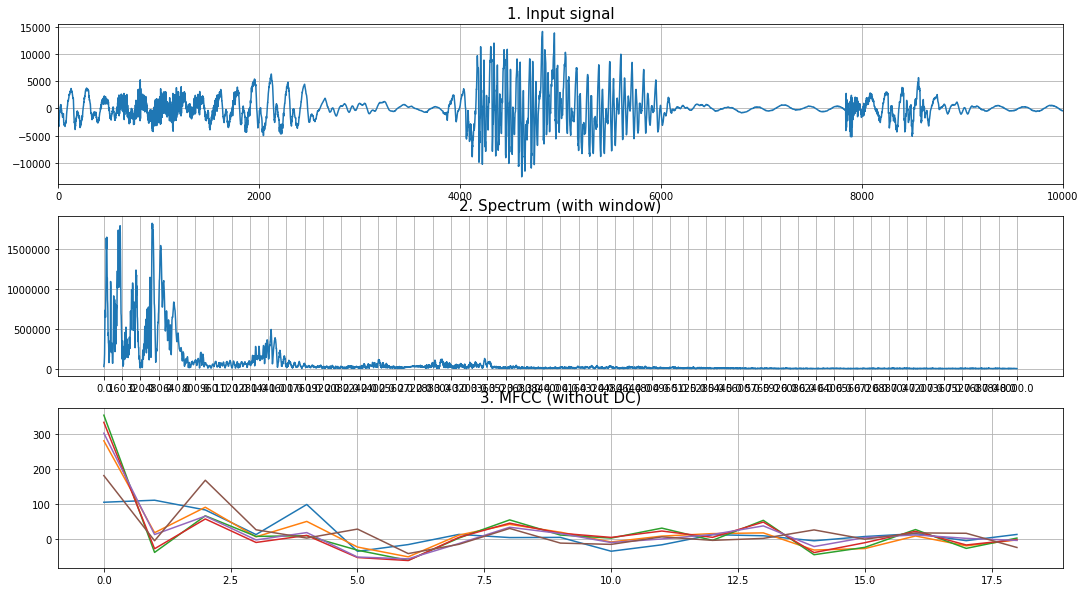

[1448.0, 845.0, 602.0, 502.0, 360.0, 684.0, 500.0, 846.0, 356.0, 461.0, 198.0, 508.0, 158.0, 696.0, 1309.0, 2735.0, 4910.0, 3826.0, 5277.0, 4667.0, 4934.0, 5008.0, 4347.0, 5537.0, 4993.0, 3999.0, 3496.0, 4610.0, 3965.0, 3741.0, 3178.0, 2837.0, 3021.0, 2494.0, 1726.0, 1280.0, 239.0, 226.0, 476.0, 495.0, 284.0, 123.0, 349.0, 561.0, 157.0, 310.0, 271.0, 454.0, 191.0, 231.0, 280.0, 399.0, 279.0, 973.0, 879.0, 1249.0, 1171.0, 1777.0, 2007.0, 1814.0, 2452.0, 1076.0, 1110.0, 511.0, 733.0, 417.0, 251.0, 297.0, 374.0, 274.0, 222.0, 206.0, 442.0, 325.0, 282.0, 253.0, 320.0, 1572.0, 982.0, 2002.0, 782.0, 1119.0, 797.0, 682.0, 658.0, 710.0, 746.0, 1185.0, 633.0, 1284.0, 2346.0, 4170.0, 3215.0, 3574.0, 2673.0, 3701.0, 2544.0, 3424.0, 3201.0, 3159.0]
pos: 67 neg: 33 / 100
mean: 46206.6989777 std: 121111.380595 mean/std: 0.381522353646
516682.637627 1336634.06192 0.386555043259
max-val: 1336634.06192 max-freq: 427.2 max/std: 11.0364034772
mfcc shape (20, 6)


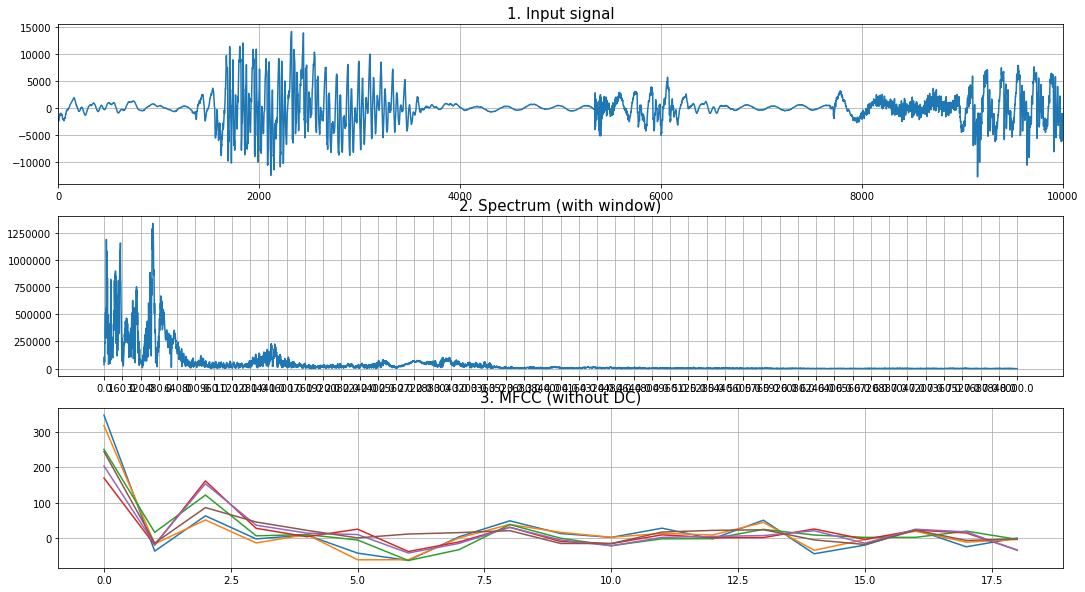

[3999.0, 3496.0, 4610.0, 3965.0, 3741.0, 3178.0, 2837.0, 3021.0, 2494.0, 1726.0, 1280.0, 239.0, 226.0, 476.0, 495.0, 284.0, 123.0, 349.0, 561.0, 157.0, 310.0, 271.0, 454.0, 191.0, 231.0, 280.0, 399.0, 279.0, 973.0, 879.0, 1249.0, 1171.0, 1777.0, 2007.0, 1814.0, 2452.0, 1076.0, 1110.0, 511.0, 733.0, 417.0, 251.0, 297.0, 374.0, 274.0, 222.0, 206.0, 442.0, 325.0, 282.0, 253.0, 320.0, 1572.0, 982.0, 2002.0, 782.0, 1119.0, 797.0, 682.0, 658.0, 710.0, 746.0, 1185.0, 633.0, 1284.0, 2346.0, 4170.0, 3215.0, 3574.0, 2673.0, 3701.0, 2544.0, 3424.0, 3201.0, 3159.0, 3571.0, 3107.0, 3051.0, 2926.0, 2899.0, 3693.0, 2347.0, 3290.0, 1441.0, 3441.0, 2335.0, 2470.0, 3620.0, 1706.0, 1202.0, 641.0, 1140.0, 1163.0, 1101.0, 1311.0, 1175.0, 1306.0, 881.0, 951.0, 1158.0]
pos: 72 neg: 28 / 100
mean: 44592.0161356 std: 108052.483463 mean/std: 0.412688489025
723034.910757 2515440.75767 0.28743865605
max-val: 2515440.75767 max-freq: 96.0 max/std: 23.2798051193
mfcc shape (20, 6)


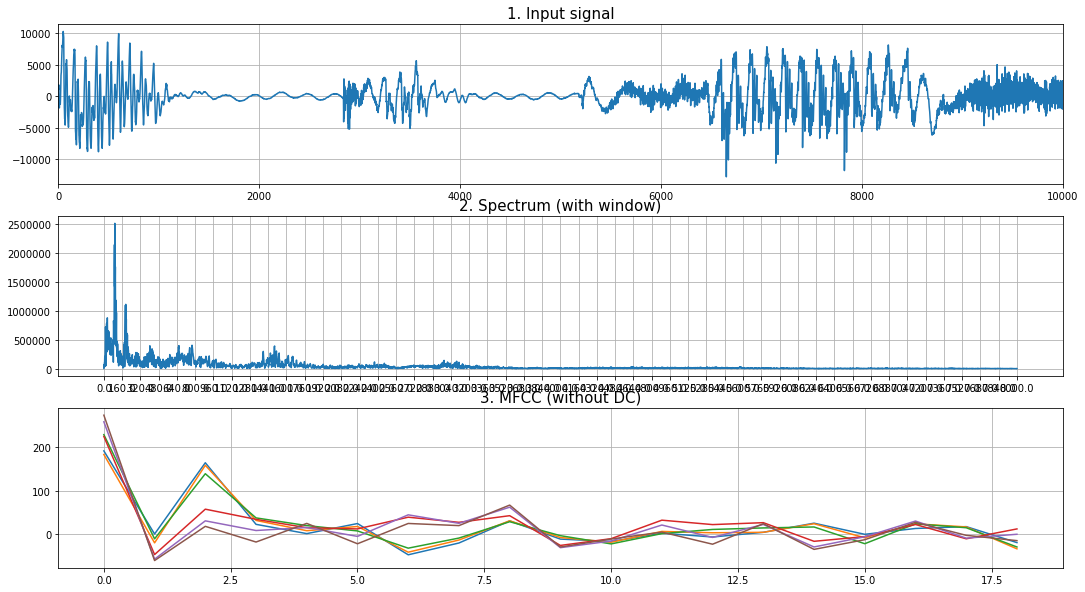

[280.0, 399.0, 279.0, 973.0, 879.0, 1249.0, 1171.0, 1777.0, 2007.0, 1814.0, 2452.0, 1076.0, 1110.0, 511.0, 733.0, 417.0, 251.0, 297.0, 374.0, 274.0, 222.0, 206.0, 442.0, 325.0, 282.0, 253.0, 320.0, 1572.0, 982.0, 2002.0, 782.0, 1119.0, 797.0, 682.0, 658.0, 710.0, 746.0, 1185.0, 633.0, 1284.0, 2346.0, 4170.0, 3215.0, 3574.0, 2673.0, 3701.0, 2544.0, 3424.0, 3201.0, 3159.0, 3571.0, 3107.0, 3051.0, 2926.0, 2899.0, 3693.0, 2347.0, 3290.0, 1441.0, 3441.0, 2335.0, 2470.0, 3620.0, 1706.0, 1202.0, 641.0, 1140.0, 1163.0, 1101.0, 1311.0, 1175.0, 1306.0, 881.0, 951.0, 1158.0, 1644.0, 1126.0, 1383.0, 1447.0, 845.0, 683.0, 1122.0, 2065.0, 3218.0, 2918.0, 2445.0, 3198.0, 3179.0, 2831.0, 2788.0, 1987.0, 3394.0, 2737.0, 2691.0, 2461.0, 2630.0, 2357.0, 2234.0, 2027.0, 2234.0]
pos: 85 neg: 15 / 100
mean: 75923.1822465 std: 161719.005025 mean/std: 0.469475942143
1430951.02634 3671227.67694 0.389774525651
max-val: 3671227.67694 max-freq: 92.8 max/std: 22.7012754399
mfcc shape (20, 6)


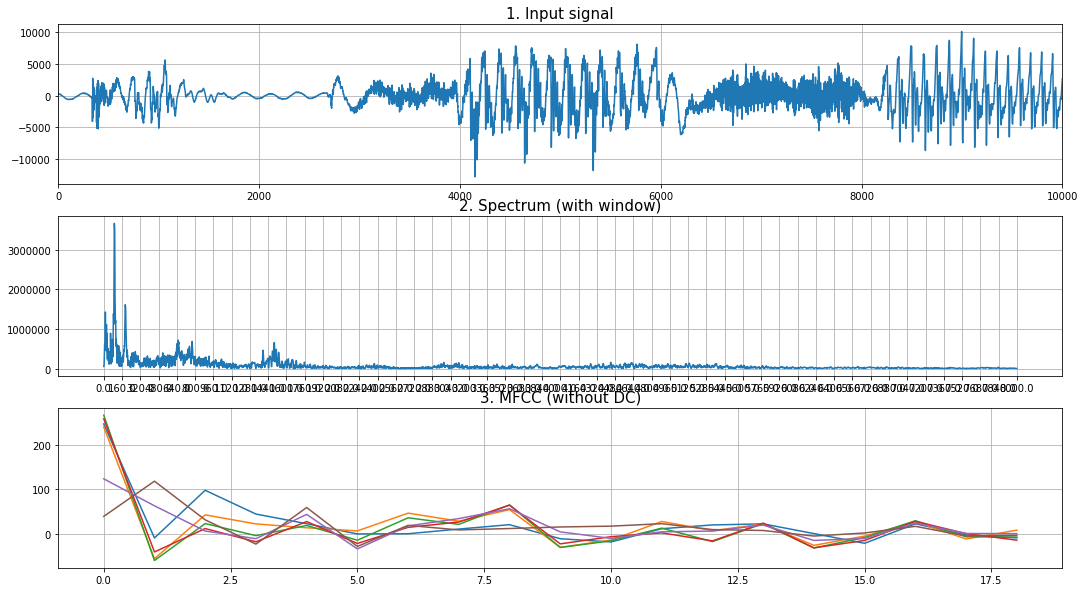

-------------------
-------------------
-------------------
[328.0, 536.0, 634.0, 856.0, 896.0, 947.0, 908.0, 546.0, 241.0, 247.0, 233.0, 209.0, 121.0, 84.0, 203.0, 142.0, 167.0, 232.0, 521.0, 1020.0, 1094.0, 1190.0, 1227.0, 1194.0, 1148.0, 1258.0, 1219.0, 1317.0, 1207.0, 1147.0, 1310.0, 1181.0, 1193.0, 1118.0, 897.0, 737.0, 479.0, 340.0, 324.0, 552.0, 665.0, 1102.0, 1639.0, 1166.0, 1187.0, 1095.0, 891.0, 737.0, 461.0, 213.0, 172.0, 215.0, 139.0, 106.0, 253.0, 666.0, 534.0, 179.0, 156.0, 157.0, 120.0, 117.0, 156.0, 137.0, 104.0, 105.0, 123.0, 234.0, 352.0, 1127.0, 1196.0, 1078.0, 921.0, 1139.0, 1121.0, 993.0, 1016.0, 1246.0, 1000.0, 842.0, 904.0, 953.0, 890.0, 900.0, 985.0, 941.0, 869.0, 907.0, 1027.0, 1027.0, 1002.0, 1042.0, 1222.0, 1110.0, 723.0, 299.0, 274.0, 195.0, 227.0, 217.0]
pos: 62 neg: 38 / 100
mean: 44528.3638548 std: 41858.6318282 mean/std: 1.06377972499
78516.0412557 472642.016017 0.166121585883
max-val: 472642.016017 max-freq: 59.2 max/std: 11.2913871136
mfcc shape (20, 6

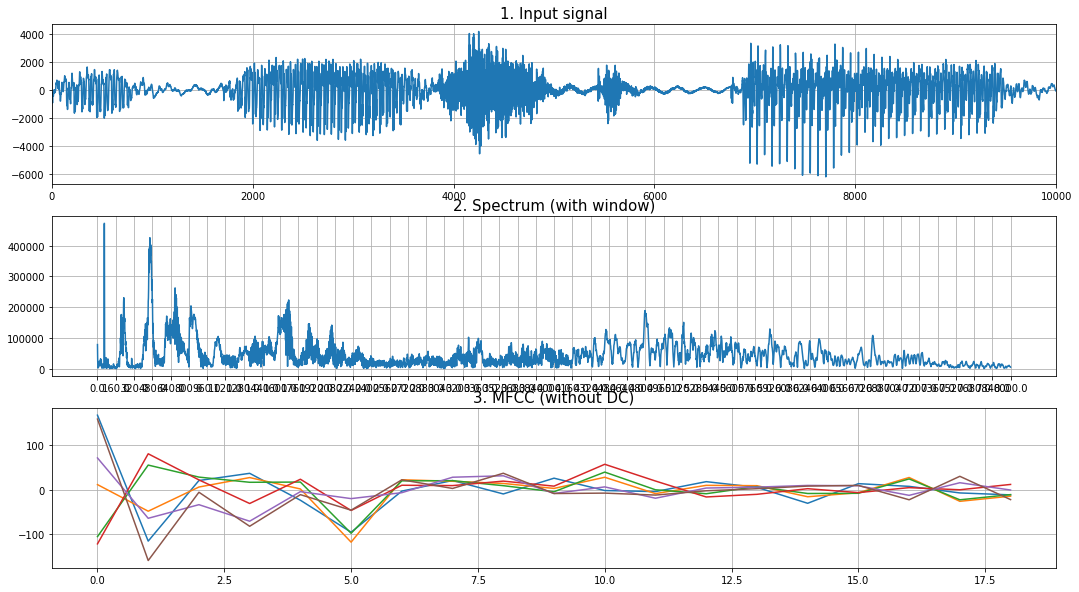

[4144.0, 3349.0, 3447.0, 1908.0, 1454.0, 784.0, 206.0, 361.0, 320.0, 257.0, 148.0, 151.0, 234.0, 173.0, 120.0, 66.0, 82.0, 75.0, 329.0, 327.0, 2952.0, 1984.0, 1460.0, 1312.0, 925.0, 681.0, 356.0, 335.0, 2061.0, 4624.0, 5665.0, 5973.0, 5614.0, 5668.0, 5714.0, 5660.0, 5589.0, 5500.0, 5394.0, 4883.0, 4314.0, 3565.0, 2758.0, 955.0, 297.0, 252.0, 342.0, 308.0, 177.0, 169.0, 137.0, 173.0, 105.0, 65.0, 84.0, 120.0, 59.0, 91.0, 80.0, 1508.0, 1236.0, 1030.0, 758.0, 336.0, 169.0, 117.0, 124.0, 131.0, 90.0, 76.0, 740.0, 1096.0, 1611.0, 2107.0, 1761.0, 3012.0, 3128.0, 3518.0, 2998.0, 3023.0, 2966.0, 2988.0, 2517.0, 2571.0, 2450.0, 2603.0, 2169.0, 1819.0, 2075.0, 2044.0, 2261.0, 2141.0, 2478.0, 2698.0, 2948.0, 2832.0, 2891.0, 2950.0, 3346.0, 3367.0]
pos: 62 neg: 38 / 100
mean: 64703.2446262 std: 189732.423639 mean/std: 0.341023655236
78087.6540841 3455045.35731 0.0226010503506
max-val: 3455045.35731 max-freq: 331.2 max/std: 18.2100944638
mfcc shape (20, 6)


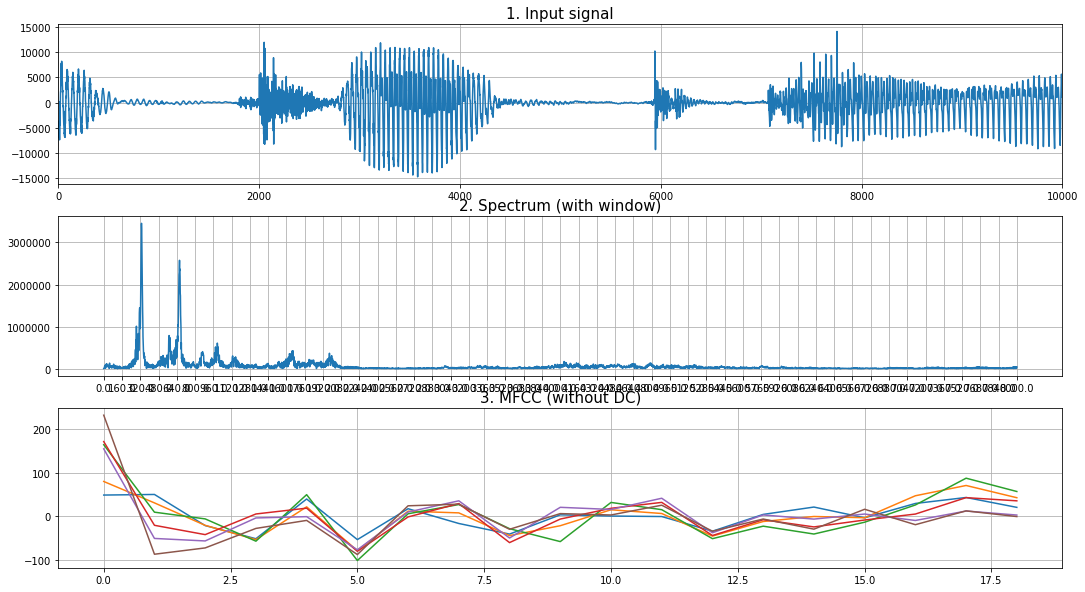

[681.0, 356.0, 335.0, 2061.0, 4624.0, 5665.0, 5973.0, 5614.0, 5668.0, 5714.0, 5660.0, 5589.0, 5500.0, 5394.0, 4883.0, 4314.0, 3565.0, 2758.0, 955.0, 297.0, 252.0, 342.0, 308.0, 177.0, 169.0, 137.0, 173.0, 105.0, 65.0, 84.0, 120.0, 59.0, 91.0, 80.0, 1508.0, 1236.0, 1030.0, 758.0, 336.0, 169.0, 117.0, 124.0, 131.0, 90.0, 76.0, 740.0, 1096.0, 1611.0, 2107.0, 1761.0, 3012.0, 3128.0, 3518.0, 2998.0, 3023.0, 2966.0, 2988.0, 2517.0, 2571.0, 2450.0, 2603.0, 2169.0, 1819.0, 2075.0, 2044.0, 2261.0, 2141.0, 2478.0, 2698.0, 2948.0, 2832.0, 2891.0, 2950.0, 3346.0, 3367.0, 3277.0, 3229.0, 3098.0, 3415.0, 3180.0, 2880.0, 2656.0, 2245.0, 1919.0, 1719.0, 1555.0, 1709.0, 1769.0, 1737.0, 1393.0, 1356.0, 1268.0, 1370.0, 1661.0, 1322.0, 2179.0, 3670.0, 4047.0, 4807.0, 4446.0]
pos: 76 neg: 24 / 100
mean: 57183.4107639 std: 154367.57451 mean/std: 0.370436673282
51560.1826665 3597581.63055 0.0143319006937
max-val: 3597581.63055 max-freq: 286.4 max/std: 23.3052934982
mfcc shape (20, 6)


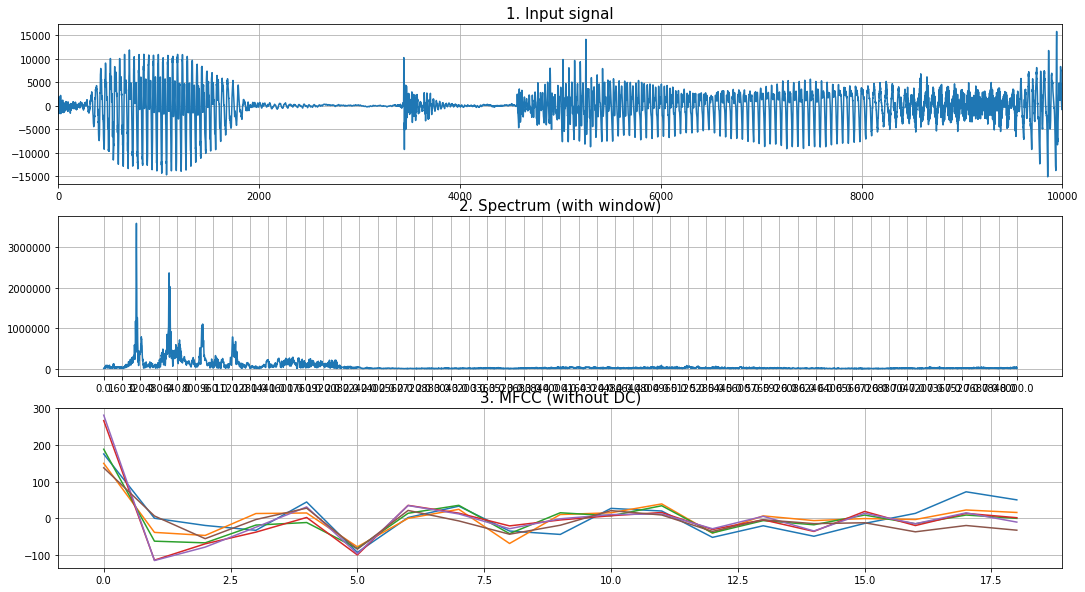

[137.0, 173.0, 105.0, 65.0, 84.0, 120.0, 59.0, 91.0, 80.0, 1508.0, 1236.0, 1030.0, 758.0, 336.0, 169.0, 117.0, 124.0, 131.0, 90.0, 76.0, 740.0, 1096.0, 1611.0, 2107.0, 1761.0, 3012.0, 3128.0, 3518.0, 2998.0, 3023.0, 2966.0, 2988.0, 2517.0, 2571.0, 2450.0, 2603.0, 2169.0, 1819.0, 2075.0, 2044.0, 2261.0, 2141.0, 2478.0, 2698.0, 2948.0, 2832.0, 2891.0, 2950.0, 3346.0, 3367.0, 3277.0, 3229.0, 3098.0, 3415.0, 3180.0, 2880.0, 2656.0, 2245.0, 1919.0, 1719.0, 1555.0, 1709.0, 1769.0, 1737.0, 1393.0, 1356.0, 1268.0, 1370.0, 1661.0, 1322.0, 2179.0, 3670.0, 4047.0, 4807.0, 4446.0, 5726.0, 6180.0, 5449.0, 5503.0, 5290.0, 5015.0, 4665.0, 5068.0, 4756.0, 4519.0, 4659.0, 4311.0, 3777.0, 4229.0, 3586.0, 3940.0, 3506.0, 3438.0, 3999.0, 3637.0, 3204.0, 3305.0, 2855.0, 3234.0, 2739.0]
pos: 84 neg: 16 / 100
mean: 90208.3782194 std: 195093.169911 mean/std: 0.462386142275
48710.7456863 4354618.02271 0.0111859973555
max-val: 4354618.02271 max-freq: 286.4 max/std: 22.320709765
mfcc shape (20, 6)


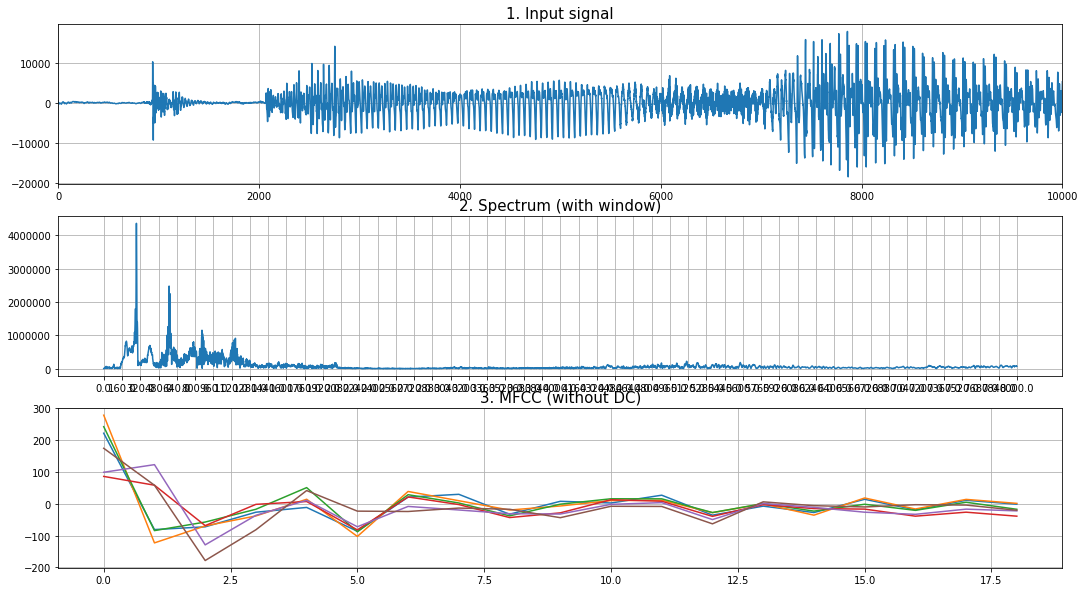

[3012.0, 3128.0, 3518.0, 2998.0, 3023.0, 2966.0, 2988.0, 2517.0, 2571.0, 2450.0, 2603.0, 2169.0, 1819.0, 2075.0, 2044.0, 2261.0, 2141.0, 2478.0, 2698.0, 2948.0, 2832.0, 2891.0, 2950.0, 3346.0, 3367.0, 3277.0, 3229.0, 3098.0, 3415.0, 3180.0, 2880.0, 2656.0, 2245.0, 1919.0, 1719.0, 1555.0, 1709.0, 1769.0, 1737.0, 1393.0, 1356.0, 1268.0, 1370.0, 1661.0, 1322.0, 2179.0, 3670.0, 4047.0, 4807.0, 4446.0, 5726.0, 6180.0, 5449.0, 5503.0, 5290.0, 5015.0, 4665.0, 5068.0, 4756.0, 4519.0, 4659.0, 4311.0, 3777.0, 4229.0, 3586.0, 3940.0, 3506.0, 3438.0, 3999.0, 3637.0, 3204.0, 3305.0, 2855.0, 3234.0, 2739.0, 2802.0, 2533.0, 2551.0, 2369.0, 2199.0, 1503.0, 1063.0, 630.0, 598.0, 728.0, 582.0, 428.0, 295.0, 250.0, 305.0, 444.0, 892.0, 1324.0, 2237.0, 1996.0, 1821.0, 2451.0, 1787.0, 1298.0, 2553.0]
pos: 95 neg: 5 / 100
mean: 135845.178295 std: 259782.589058 mean/std: 0.522918717485
46311.4913389 1864385.09476 0.0248400888148
max-val: 1864385.09476 max-freq: 756.8 max/std: 7.17671304117
mfcc shape (20, 6)

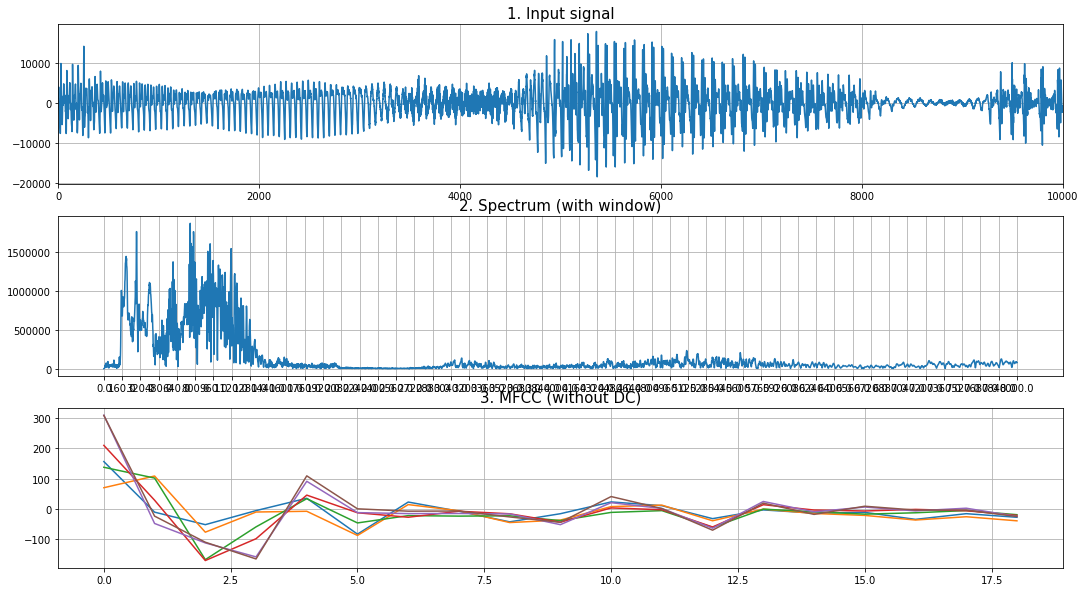

[3277.0, 3229.0, 3098.0, 3415.0, 3180.0, 2880.0, 2656.0, 2245.0, 1919.0, 1719.0, 1555.0, 1709.0, 1769.0, 1737.0, 1393.0, 1356.0, 1268.0, 1370.0, 1661.0, 1322.0, 2179.0, 3670.0, 4047.0, 4807.0, 4446.0, 5726.0, 6180.0, 5449.0, 5503.0, 5290.0, 5015.0, 4665.0, 5068.0, 4756.0, 4519.0, 4659.0, 4311.0, 3777.0, 4229.0, 3586.0, 3940.0, 3506.0, 3438.0, 3999.0, 3637.0, 3204.0, 3305.0, 2855.0, 3234.0, 2739.0, 2802.0, 2533.0, 2551.0, 2369.0, 2199.0, 1503.0, 1063.0, 630.0, 598.0, 728.0, 582.0, 428.0, 295.0, 250.0, 305.0, 444.0, 892.0, 1324.0, 2237.0, 1996.0, 1821.0, 2451.0, 1787.0, 1298.0, 2553.0, 1983.0, 2488.0, 3131.0, 3709.0, 2805.0, 2656.0, 2485.0, 2314.0, 2314.0, 2854.0, 2516.0, 2650.0, 2348.0, 2127.0, 1900.0, 1587.0, 907.0, 273.0, 237.0, 185.0, 390.0, 155.0, 137.0, 110.0, 79.0]
pos: 87 neg: 13 / 100
mean: 102664.884992 std: 224930.209094 mean/std: 0.45642995401
60392.9008184 1793000.06607 0.0336825982115
max-val: 1793000.06607 max-freq: 910.4 max/std: 7.97136175389
mfcc shape (20, 6)


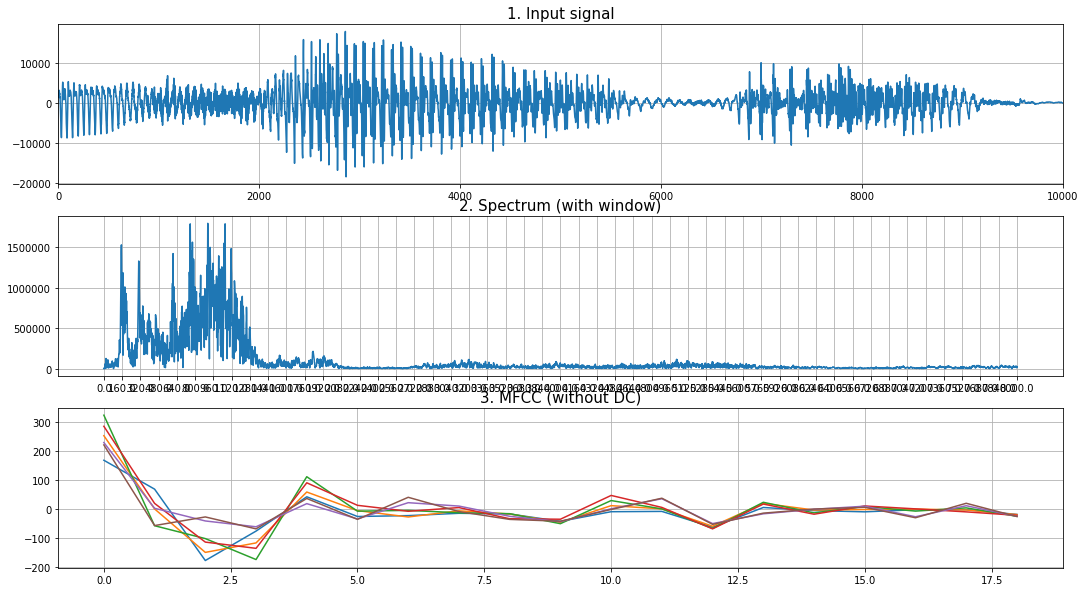

[5726.0, 6180.0, 5449.0, 5503.0, 5290.0, 5015.0, 4665.0, 5068.0, 4756.0, 4519.0, 4659.0, 4311.0, 3777.0, 4229.0, 3586.0, 3940.0, 3506.0, 3438.0, 3999.0, 3637.0, 3204.0, 3305.0, 2855.0, 3234.0, 2739.0, 2802.0, 2533.0, 2551.0, 2369.0, 2199.0, 1503.0, 1063.0, 630.0, 598.0, 728.0, 582.0, 428.0, 295.0, 250.0, 305.0, 444.0, 892.0, 1324.0, 2237.0, 1996.0, 1821.0, 2451.0, 1787.0, 1298.0, 2553.0, 1983.0, 2488.0, 3131.0, 3709.0, 2805.0, 2656.0, 2485.0, 2314.0, 2314.0, 2854.0, 2516.0, 2650.0, 2348.0, 2127.0, 1900.0, 1587.0, 907.0, 273.0, 237.0, 185.0, 390.0, 155.0, 137.0, 110.0, 79.0, 99.0, 119.0, 77.0, 136.0, 65.0, 409.0, 489.0, 365.0, 524.0, 407.0, 1170.0, 1698.0, 1905.0, 2273.0, 2890.0, 2655.0, 2722.0, 2931.0, 2926.0, 3029.0, 3295.0, 3420.0, 3411.0, 2352.0, 873.0]
pos: 78 neg: 22 / 100
mean: 71914.0191401 std: 143829.4375 mean/std: 0.499995135835
61596.8185608 1601936.00969 0.0384514850708
max-val: 1601936.00969 max-freq: 169.6 max/std: 11.1377478597
mfcc shape (20, 6)


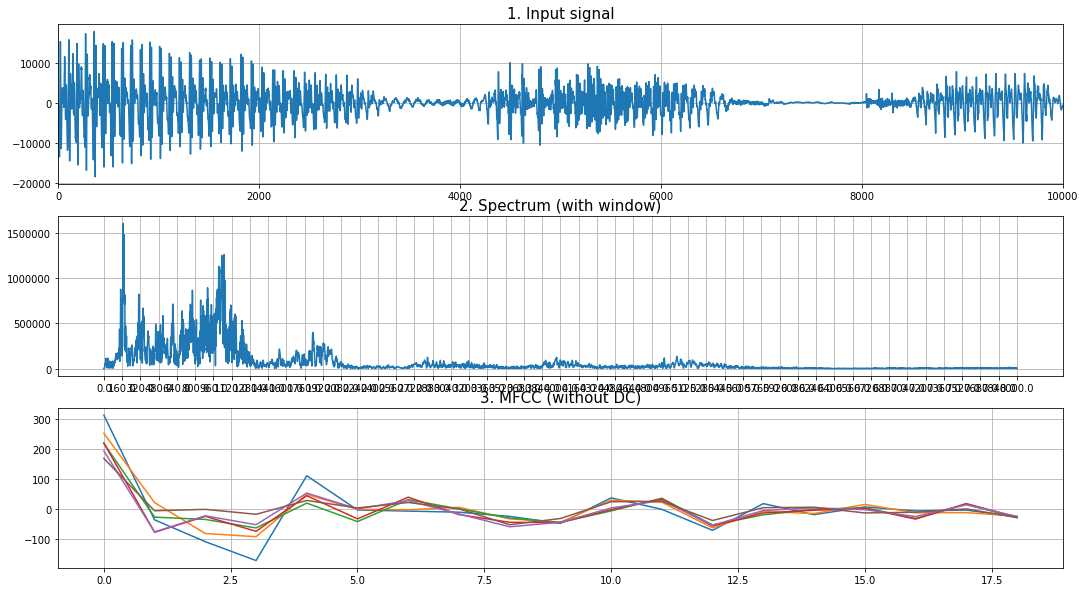

[2802.0, 2533.0, 2551.0, 2369.0, 2199.0, 1503.0, 1063.0, 630.0, 598.0, 728.0, 582.0, 428.0, 295.0, 250.0, 305.0, 444.0, 892.0, 1324.0, 2237.0, 1996.0, 1821.0, 2451.0, 1787.0, 1298.0, 2553.0, 1983.0, 2488.0, 3131.0, 3709.0, 2805.0, 2656.0, 2485.0, 2314.0, 2314.0, 2854.0, 2516.0, 2650.0, 2348.0, 2127.0, 1900.0, 1587.0, 907.0, 273.0, 237.0, 185.0, 390.0, 155.0, 137.0, 110.0, 79.0, 99.0, 119.0, 77.0, 136.0, 65.0, 409.0, 489.0, 365.0, 524.0, 407.0, 1170.0, 1698.0, 1905.0, 2273.0, 2890.0, 2655.0, 2722.0, 2931.0, 2926.0, 3029.0, 3295.0, 3420.0, 3411.0, 2352.0, 873.0, 587.0, 502.0, 519.0, 403.0, 304.0, 247.0, 220.0, 309.0, 338.0, 598.0, 1474.0, 2410.0, 1710.0, 2028.0, 1983.0, 1687.0, 1934.0, 1704.0, 2110.0, 1780.0, 2043.0, 1622.0, 1962.0, 1174.0, 1890.0]
pos: 72 neg: 28 / 100
mean: 53705.7846755 std: 124337.15801 mean/std: 0.431936723784
63242.6836494 1938558.73332 0.0326235581943
max-val: 1938558.73332 max-freq: 169.6 max/std: 15.5911455943
mfcc shape (20, 6)


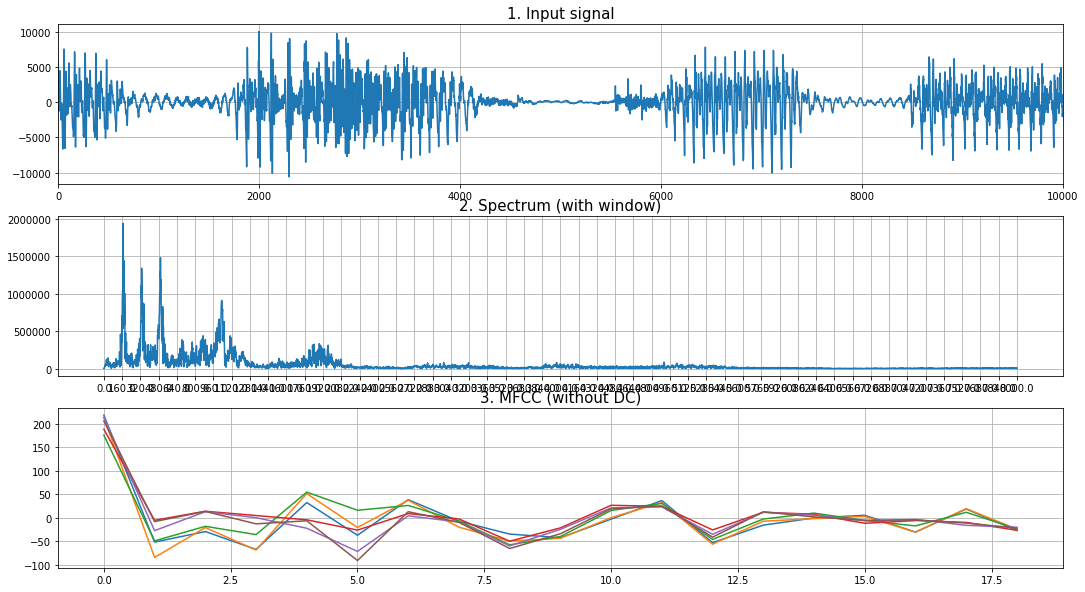

[1983.0, 2488.0, 3131.0, 3709.0, 2805.0, 2656.0, 2485.0, 2314.0, 2314.0, 2854.0, 2516.0, 2650.0, 2348.0, 2127.0, 1900.0, 1587.0, 907.0, 273.0, 237.0, 185.0, 390.0, 155.0, 137.0, 110.0, 79.0, 99.0, 119.0, 77.0, 136.0, 65.0, 409.0, 489.0, 365.0, 524.0, 407.0, 1170.0, 1698.0, 1905.0, 2273.0, 2890.0, 2655.0, 2722.0, 2931.0, 2926.0, 3029.0, 3295.0, 3420.0, 3411.0, 2352.0, 873.0, 587.0, 502.0, 519.0, 403.0, 304.0, 247.0, 220.0, 309.0, 338.0, 598.0, 1474.0, 2410.0, 1710.0, 2028.0, 1983.0, 1687.0, 1934.0, 1704.0, 2110.0, 1780.0, 2043.0, 1622.0, 1962.0, 1174.0, 1890.0, 1627.0, 1958.0, 2006.0, 1613.0, 1251.0, 1646.0, 1005.0, 1489.0, 1094.0, 1167.0, 858.0, 540.0, 697.0, 1141.0, 1377.0, 1844.0, 1590.0, 1225.0, 1387.0, 1144.0, 1288.0, 1013.0, 1247.0, 1175.0, 835.0]
pos: 77 neg: 23 / 100
mean: 55000.4677693 std: 132969.948273 mean/std: 0.413630812703
69693.5540824 1931528.10668 0.0360820812502
max-val: 1931528.10668 max-freq: 496.0 max/std: 14.5260499215
mfcc shape (20, 6)


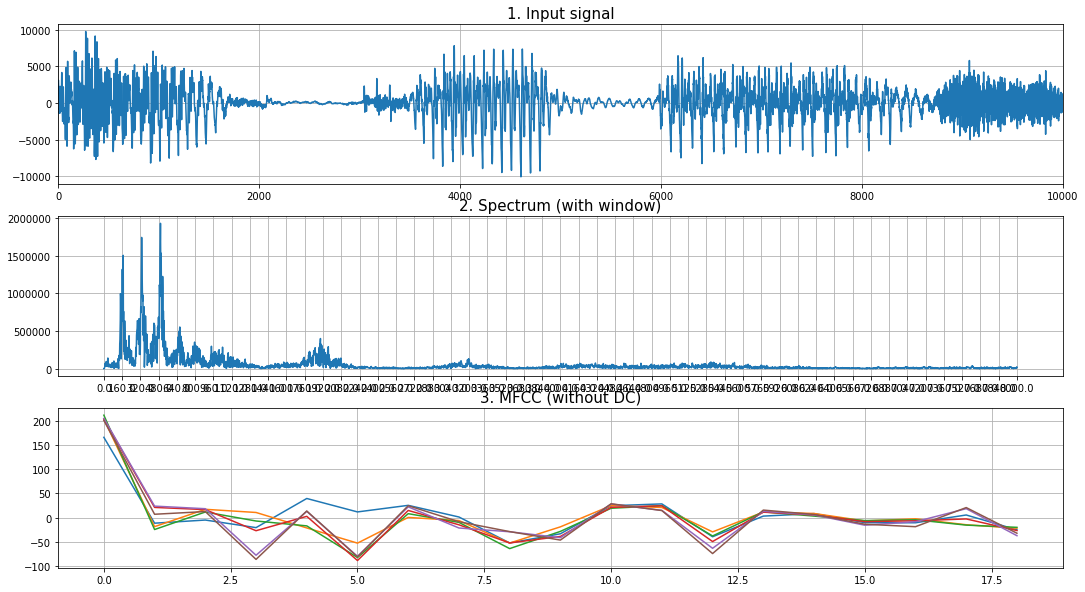

[99.0, 119.0, 77.0, 136.0, 65.0, 409.0, 489.0, 365.0, 524.0, 407.0, 1170.0, 1698.0, 1905.0, 2273.0, 2890.0, 2655.0, 2722.0, 2931.0, 2926.0, 3029.0, 3295.0, 3420.0, 3411.0, 2352.0, 873.0, 587.0, 502.0, 519.0, 403.0, 304.0, 247.0, 220.0, 309.0, 338.0, 598.0, 1474.0, 2410.0, 1710.0, 2028.0, 1983.0, 1687.0, 1934.0, 1704.0, 2110.0, 1780.0, 2043.0, 1622.0, 1962.0, 1174.0, 1890.0, 1627.0, 1958.0, 2006.0, 1613.0, 1251.0, 1646.0, 1005.0, 1489.0, 1094.0, 1167.0, 858.0, 540.0, 697.0, 1141.0, 1377.0, 1844.0, 1590.0, 1225.0, 1387.0, 1144.0, 1288.0, 1013.0, 1247.0, 1175.0, 835.0, 1062.0, 845.0, 967.0, 736.0, 695.0, 532.0, 549.0, 363.0, 289.0, 135.0, 93.0, 53.0, 62.0, 49.0, 20.0, 66.0, 110.0, 315.0, 77.0, 193.0, 1153.0, 771.0, 1556.0, 2842.0, 2234.0]
pos: 72 neg: 28 / 100
mean: 71915.9245399 std: 103255.985398 mean/std: 0.69648189655
91706.5399387 1336060.98473 0.0686394865108
max-val: 1336060.98473 max-freq: 145.6 max/std: 12.9393078724
mfcc shape (20, 6)


KeyboardInterrupt: 

In [104]:
e = 0
for x,y in zip(x_train[500:700],y_train[500:700]):
    if y == 0:
        fft_plot(x,16000)
        e +=1
        write_wav("./{}_man.wav".format(e),16000,x)
    if e>12:
        break
    
print("-------------------")
print("-------------------")
print("-------------------")
        
e = 0
for x,y in zip(x_train[:100],y_train[:100]):
    if y == 1:
        fft_plot(x,16000)
        e +=1
        write_wav("./{}_woman.wav".format(e),16000,x)
    if e>12:
        break
        

In [164]:
print(x_train.shape)
print(x_test.shape)

(5200, 4096)
(391, 4096)


In [165]:
%%time

#     mfccs = mfcc(data, sr=fs, n_mfcc=30, n_fft=1024)
X_train = np.array([mfcc(x, sr=16000, n_mfcc=13, n_fft=4096) for x in x_train])
X_test = np.array([mfcc(x, sr=16000, n_mfcc=13, n_fft=4096) for x in x_test])

CPU times: user 1min 42s, sys: 23.4 s, total: 2min 6s
Wall time: 2min 5s


In [166]:
with open("mfcc_lstm_data_4096_train_test.dump","wb") as f:
    pickle.dump((X_train,X_test,y_train,y_test),f)

In [121]:
# Xx_train = np.array([x.T for x in X_train]).reshape(8500*6,13)
# Xx_test = np.array([x.T for x in X_test]).reshape(-1,13)

In [149]:
# print(y_train.shape)
# Yy_train = np.array([np.zeros(6) if y == 0. else np.ones(6) for y in y_train]).flatten()
# Yy_test = np.array([np.zeros(6) if y == 0. else np.ones(6) for y in y_test]).flatten()
# print(Yy_train.shape)

(8500,)
(51000,)


In [122]:
# Xd_train = np.array([[x,librosa.feature.delta(x)] for x in Xx_train])
# Xd_test = np.array([[x,librosa.feature.delta(x)] for x in Xx_test])

In [123]:
# Xdd_train = np.array([np.r_[x,y,librosa.feature.delta(y)] for x,y in Xd_train])
# Xdd_test = np.array([np.r_[x,y,librosa.feature.delta(y)] for x,y in Xd_test])

In [126]:
# print(Xdd_train[0])

[  1.64801336e+03   1.66183849e+02  -1.14969141e+02   2.03092165e+01
   3.63756207e+01  -2.37318889e+01  -9.51647015e+01  -3.32859756e+00
   2.02712051e+01  -9.69280234e+00   2.55111375e+01  -2.04703371e+00
  -4.43720132e+00  -2.72290965e+02  -2.75671417e+02  -2.55951635e+02
  -2.01056479e+02  -1.17065636e+02  -7.94335859e+00   7.66849197e+00
   3.58260488e-01   2.27984584e+00   5.95273851e+00   5.29688575e+00
  -1.63327952e+00  -2.42256113e+00   1.43983830e+01   2.80312453e+01
   3.82991041e+01   4.34136232e+01   4.41120942e+01   4.04792445e+01
   3.18835720e+01   1.97863985e+01   7.97256340e+00  -1.52600160e-01
  -1.09495849e+00  -8.28342560e-01  -1.00272837e+00]


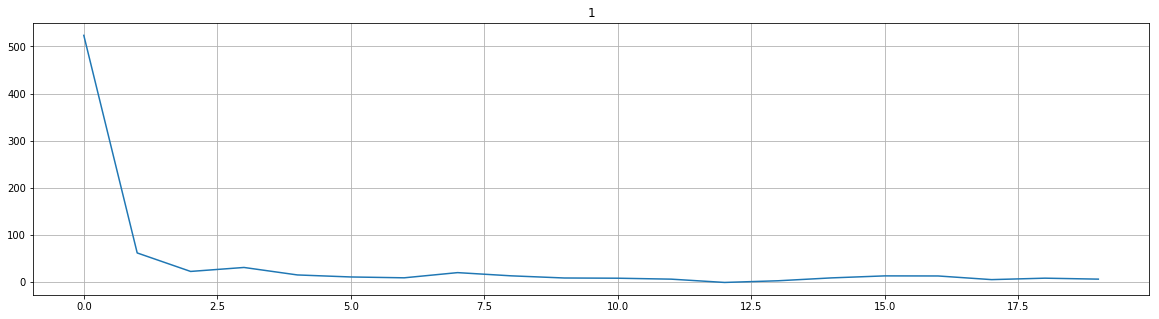

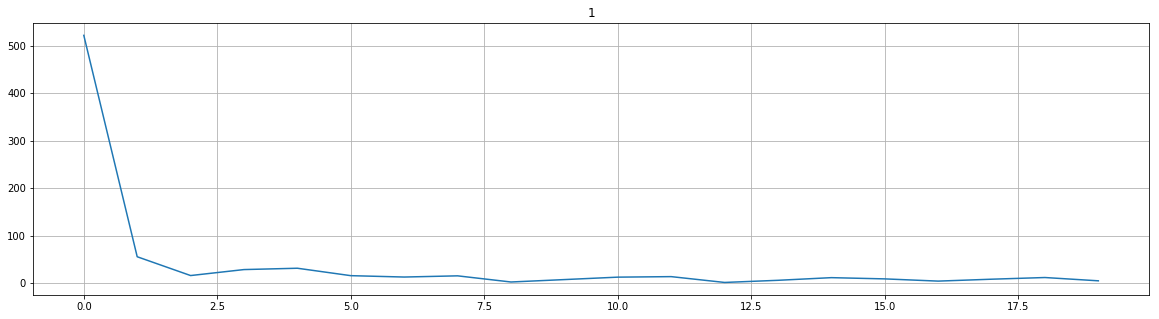

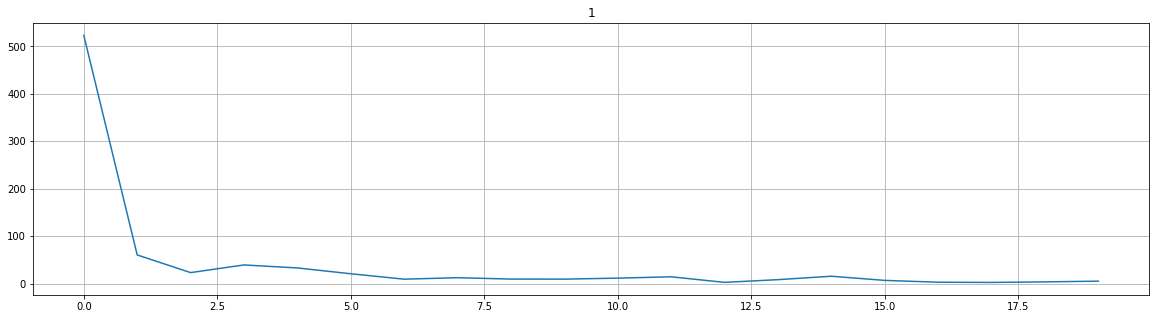

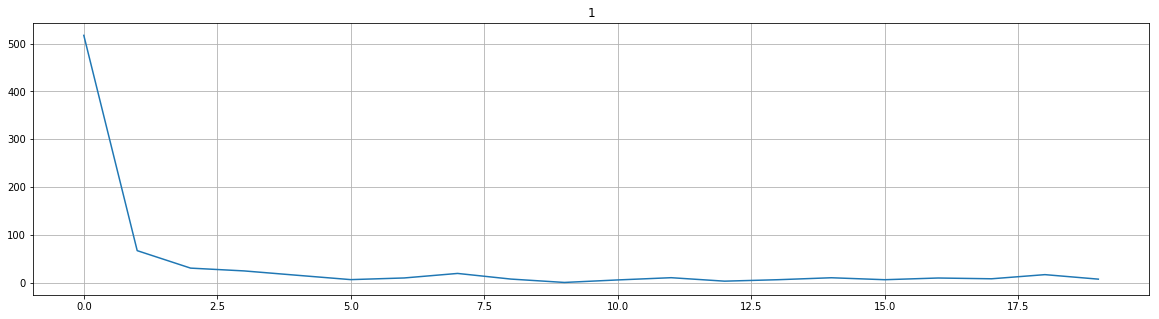

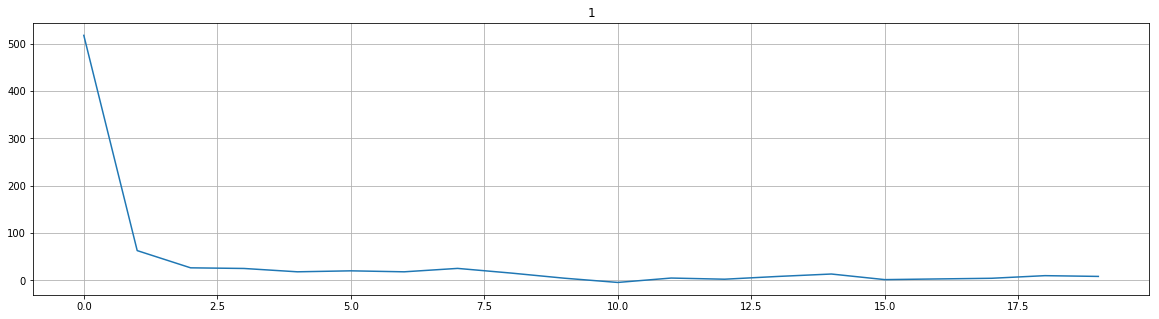

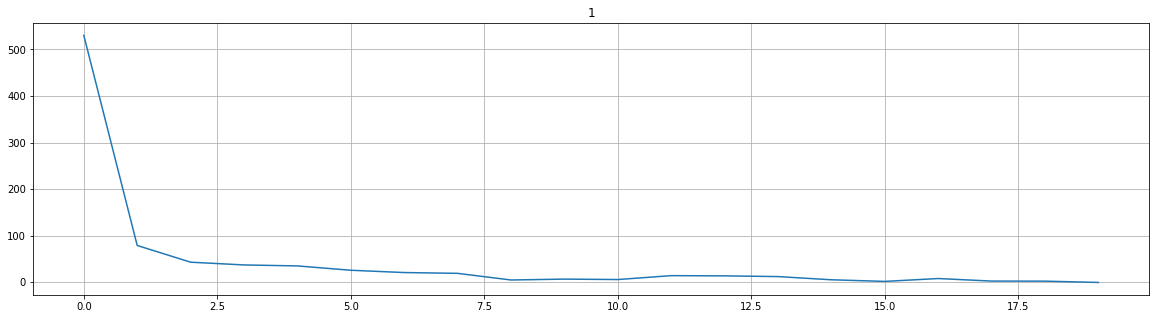

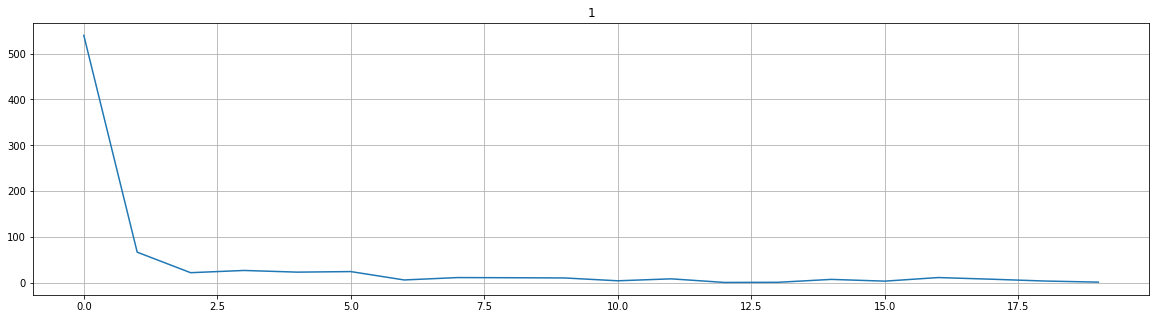

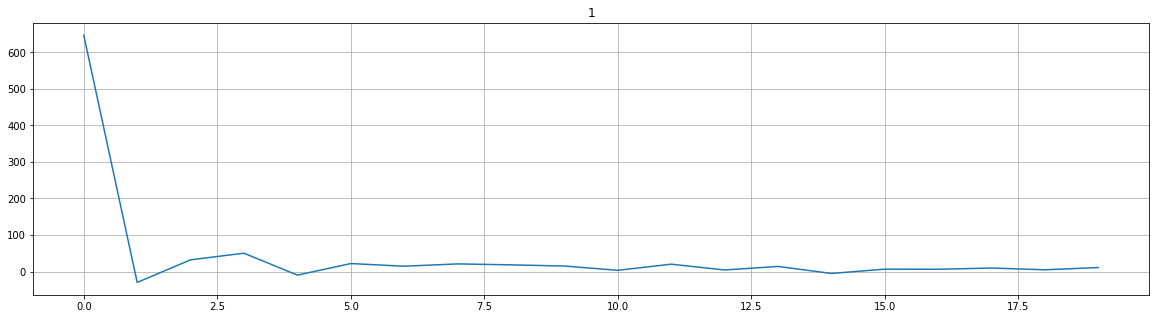

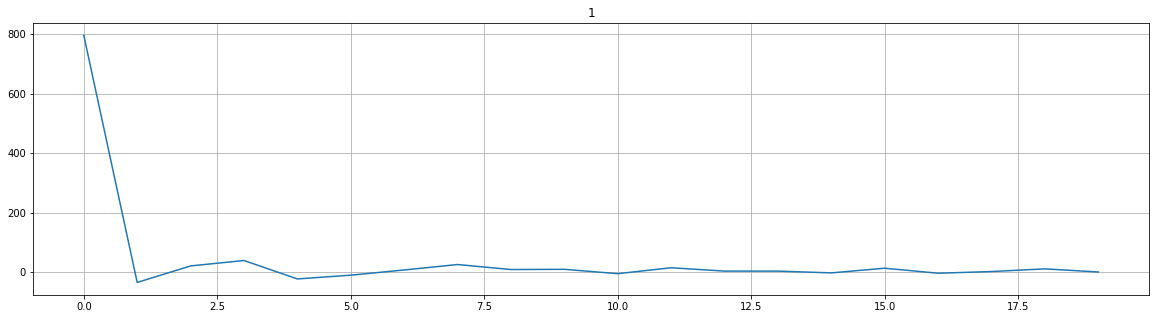

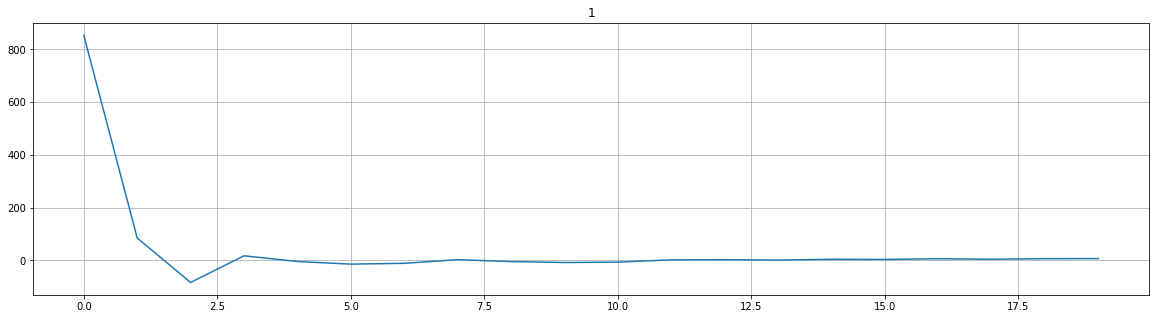

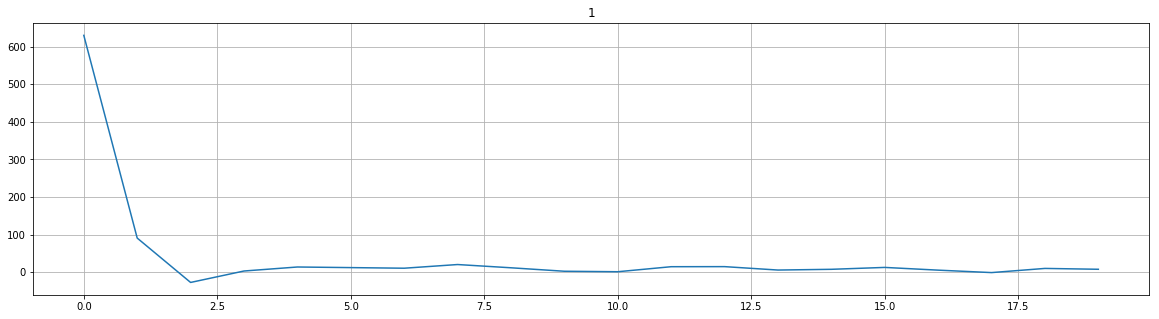

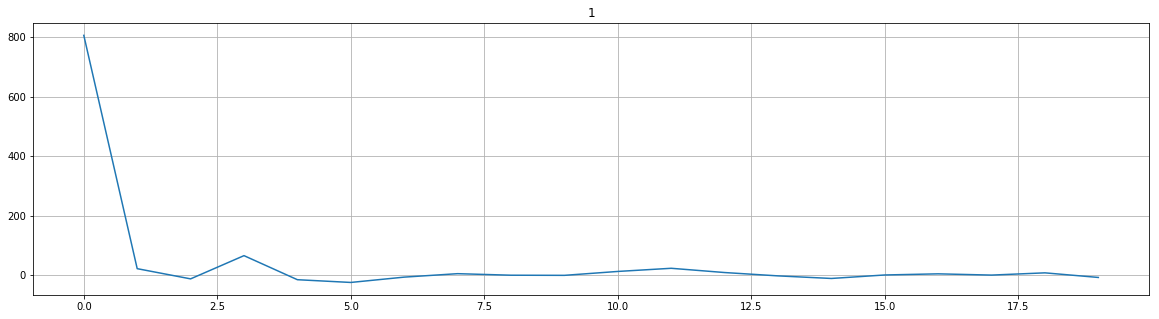

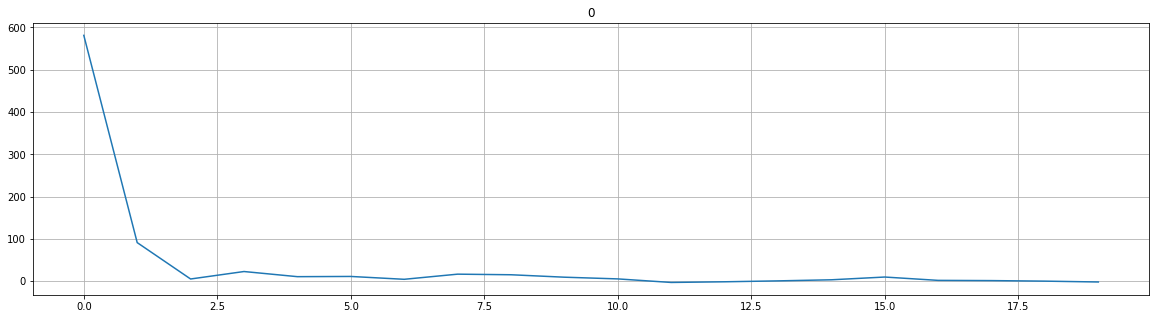

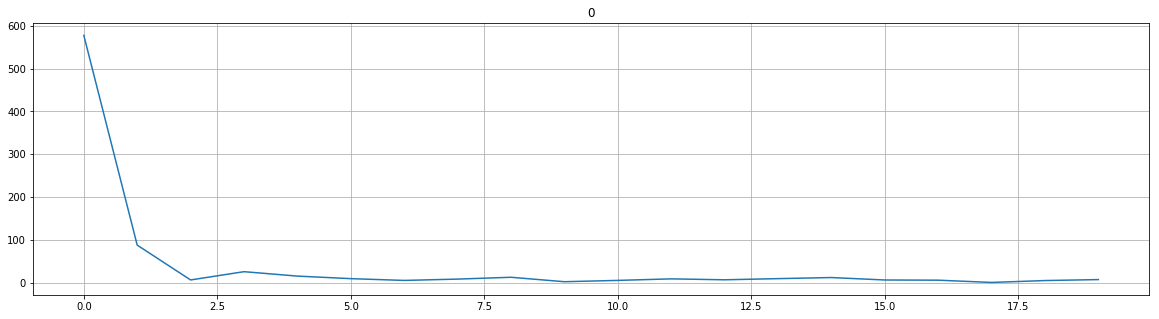

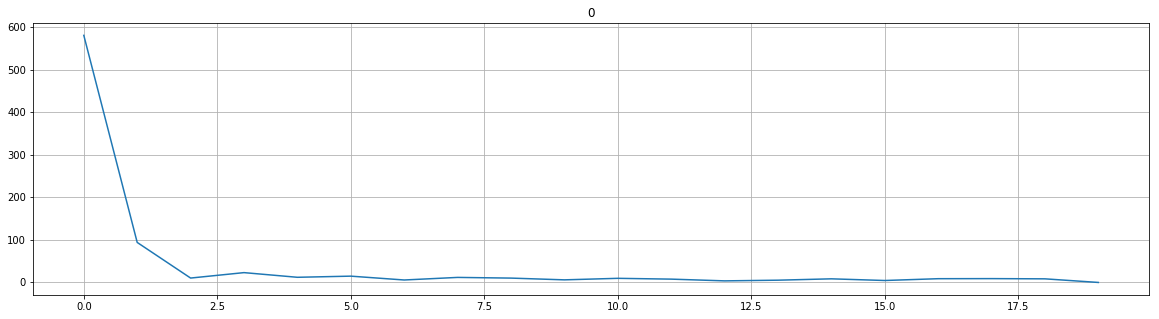

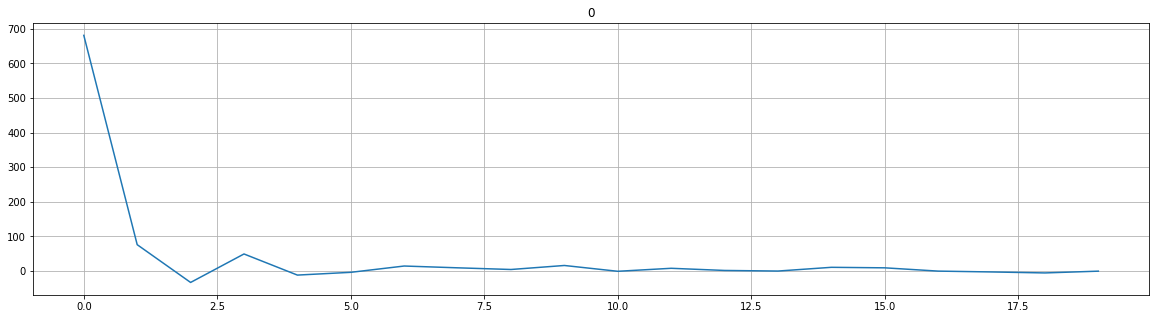

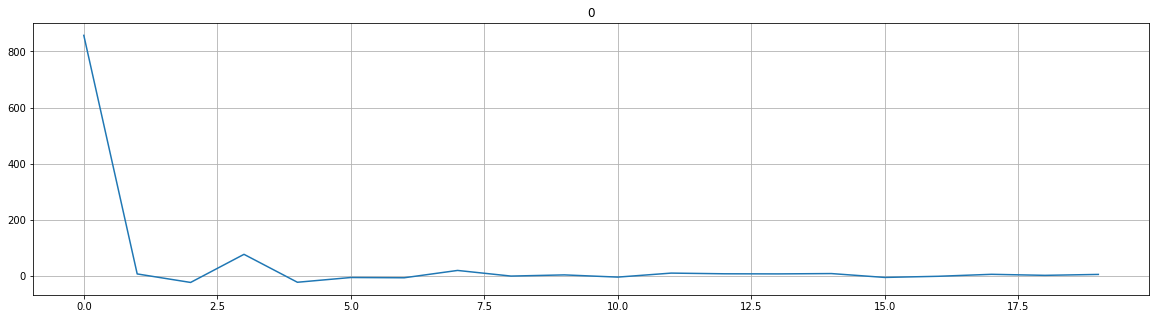

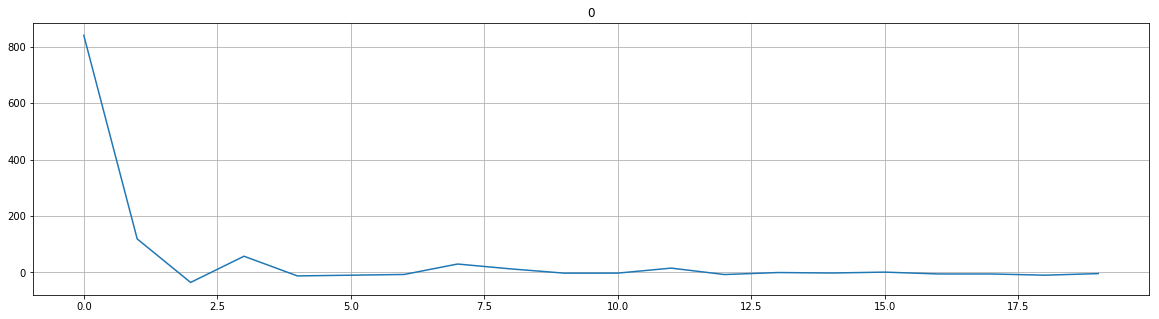

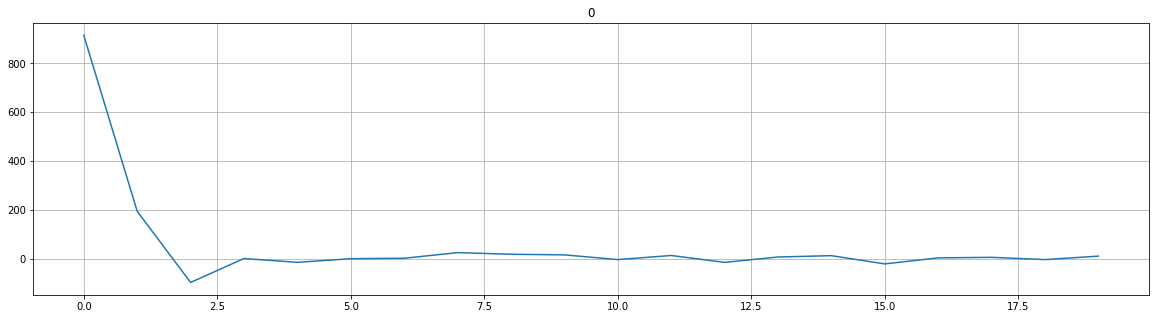

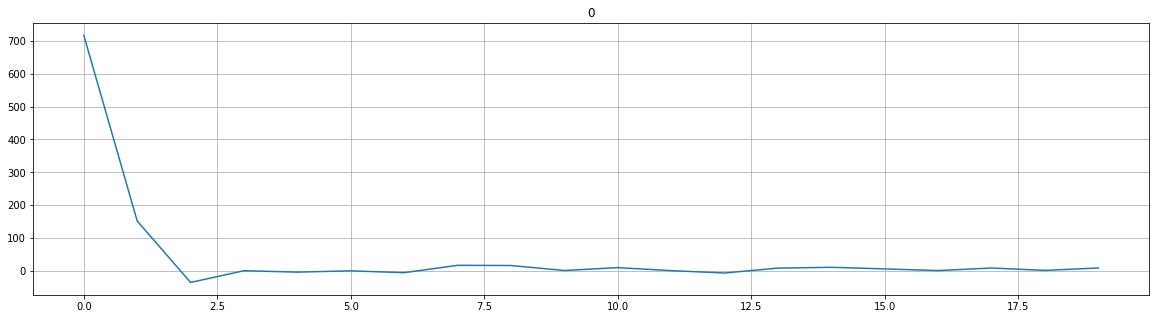

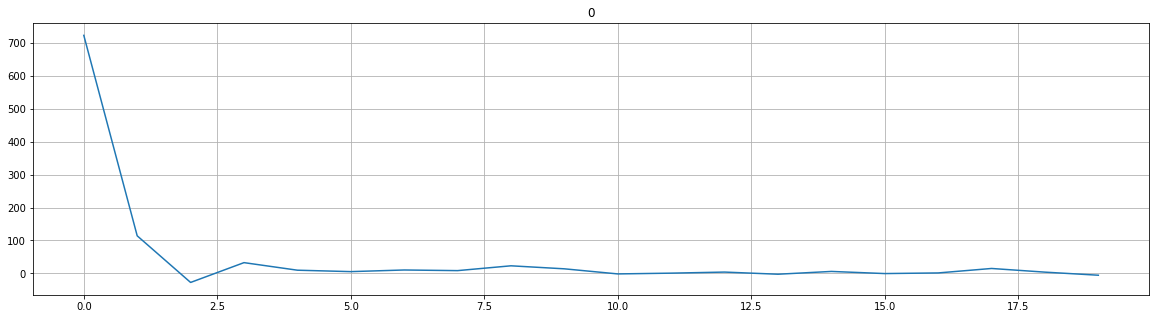

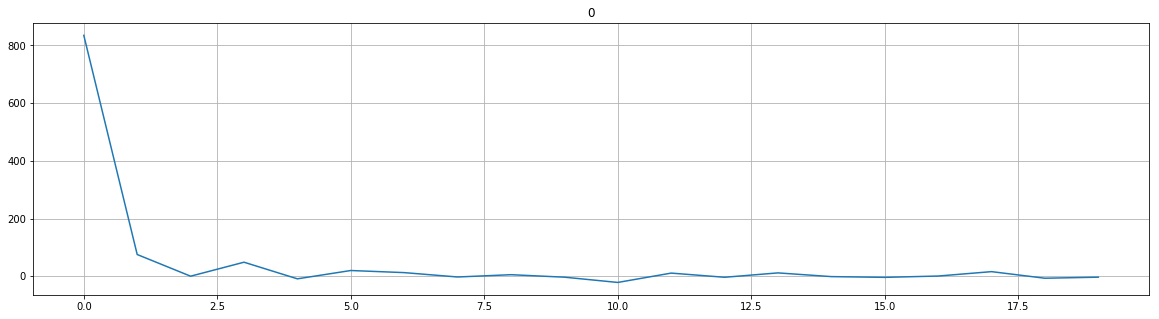

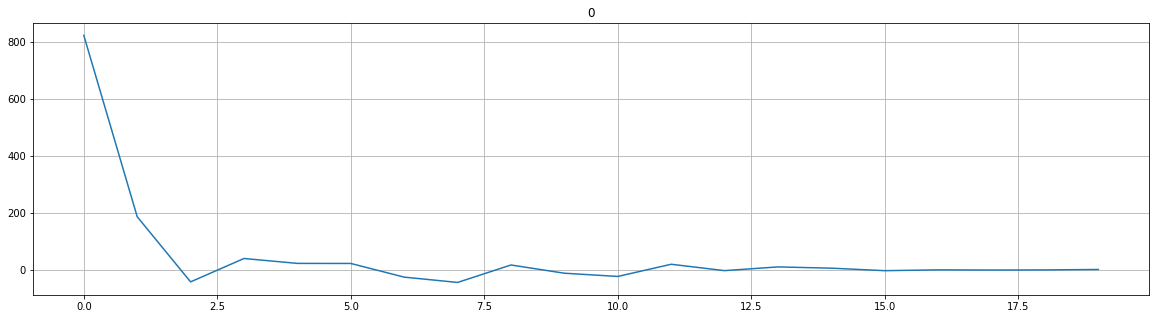

In [69]:
# for e,(x,y) in enumerate(zip(X_train,y_train)):
#     plt.figure(figsize=(20,5))
#     plt.plot(x)
#     plt.grid()
#     plt.title(y)
#     plt.show()
#     if e > 10:
#         break
# e=0
# for x,y in zip(X_train,y_train):
#     if y == 0 :
#         e+=1 
#         plt.figure(figsize=(20,5))
#         plt.plot(x)
#         plt.grid()
#         plt.title(y)
#         plt.show()
#     if e > 10:
#         break

In [127]:
# Xdd_train = Xdd_train.reshape(-1,39,1)
# Xdd_test = Xdd_test.reshape(-1,39,1)

In [168]:
X_train = X_train.reshape(-1,13,1)
X_test = X_test.reshape(-1,13,1)

In [169]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Activation
from keras.layers import LSTM, Dense, Embedding, Bidirectional

In [170]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [153]:
with open("mfcc_lstm_data_10000_train_test.dump", "wb") as f:
    pickle.dump((Xdd_train,Y_train,Xdd_test,Y_test),f)

In [173]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 50

# LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(13,1)))

model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_20 (Activation)   (None, 2)                 0         
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 7s - loss: 0.6570 - acc: 0.6331 - val_loss: 0.6276 - val_acc: 0.6496
Epoch 2/50
5200/5200 [==============================] - 6s - loss: 0.5856 - acc: 0.6862 - val_loss: 0.6461 - val_acc: 0.6522
Epoch 3/50
5200/5200 [==============================] - 6s 

In [174]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 50

# Deep LSTM model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(13,1), return_sequences=True))
model2.add(LSTM(64))


model2.add(Dense(2))
model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model2.summary()

# フィッティング(学習)
history = model2.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 13, 64)            16896     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 130       
_________________________________________________________________
activation_21 (Activation)   (None, 2)                 0         
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 10s - loss: 0.6736 - acc: 0.6098 - val_loss: 0.6421 - val_acc: 0.6419
Epoch 2/50
5200/5200 [=============================

In [175]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

Xx_train = X_train.reshape(-1,13)
Xx_test = X_test.reshape(-1,13)

num_classes = 2
batch_size = 50
epochs = 50

# DNN model
model3 = Sequential()
model3.add(Dense(64, input_shape=(13,)))
model3.add(Dense(64))


model3.add(Dense(2))
model3.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.summary()

# フィッティング(学習)
history = model3.fit(Xx_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(Xx_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 130       
_________________________________________________________________
activation_22 (Activation)   (None, 2)                 0         
Total params: 5,186
Trainable params: 5,186
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 1s - loss: 7.6282 - acc: 0.5267 - val_loss: 7.4613 - val_acc: 0.5371
Epoch 2/50
5200/5200 [==============================] 

In [177]:
## Bidirectional version

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 50

# BiLSTM model
model4 = Sequential()
model4.add(Bidirectional(LSTM(64), input_shape=(13,1)))
model4.add(Dense(2))
model4.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model4.summary()

# フィッティング(学習)
history = model4.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_23 (Activation)   (None, 2)                 0         
Total params: 34,050
Trainable params: 34,050
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 9s - loss: 0.6849 - acc: 0.6071 - val_loss: 0.7393 - val_acc: 0.5831
Epoch 2/50
5200/5200 [==============================] - 6s - loss: 0.6216 - acc: 0.6606 - val_loss: 0.6553 - val_acc: 0.6394
Epoch 3/50
5200/5200 [==============================] - 5s 

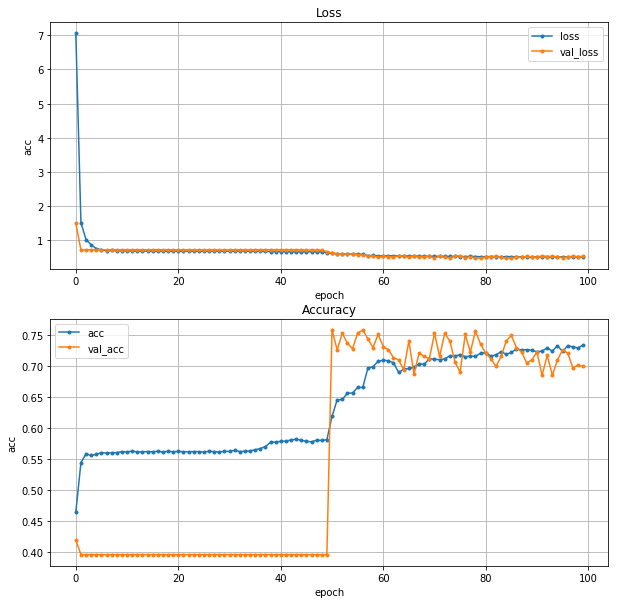

In [94]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')

In [29]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np
import librosa


def fft_plot(data,fs):
    # fs = Sampling rate
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
#     print(data_length,delta_freq)
#     print("mean:",np.mean(data),"std:",np.std(data),"mean/std:",np.mean(data)/np.std(data))

    
    # 閾値
    abs_sum = []
    for i in range(int(L/100)):
        d = data[i*100:(i+1)*100]
        abs_sum.append(np.sum(np.array([np.abs(x) for x in d]))//100.)
    print(abs_sum)
    pos = 0; neg = 0
    for i in abs_sum:
        if i >= 800.:
            pos += 1
        else:
            neg += 1
    print("pos:",pos,"neg:",neg,"/",int(L/100))
    
    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum = fft(data * win) # 窓関数あり
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    mean = np.mean(half_spectrum)
    std = np.std(half_spectrum)
    max_val = np.max(half_spectrum)
    max_freq = np.argmax(half_spectrum)*delta_freq
    
    print("mean:",mean,"std:",std,"mean/std:",mean/std)
    
    print(np.max(half_spectrum[:10]),np.max(half_spectrum[10:]),np.max(half_spectrum[:10])/np.max(half_spectrum[10:]))
    print("max-val:",max_val,"max-freq:",max_freq,"max/std:",max_val/std)
    
    # mfccs translation
    mfccs = mfcc(data, sr=fs, n_mfcc=20, n_fft=4096)
    print("mfcc shape",mfccs.shape)
    
#     if mfccs[1] > mfccs[2]:
#         print("----OK----")
#     else:
#         print("----NG----")

    
    # 図を表示
    fig = plt.figure(figsize=(18,10))

    fig.add_subplot(311)
    plt.plot(data)
    plt.xlim([0, L])
    plt.grid()
    plt.title("1. Input signal", fontsize = 15)

    fig.add_subplot(312)
#     plt.plot(np.arange(len(spectrum))*delta_freq, spectrum)
    plt.plot(half_spectrum)
#     plt.xlim([0, len(half_spectrum)/10])
    plt.xticks([i for i in range(len(half_spectrum))][::100],[i*delta_freq for i in range(len(half_spectrum))][::100])
    plt.grid()
    plt.title("2. Spectrum (with window)", fontsize = 15)

    fig.add_subplot(313)
    plt.plot(mfccs[1:])
#     plt.xticks(np.arange(0,30),np.arange(1,31))
    plt.grid()
    plt.title("3. MFCC (without DC)", fontsize = 15)
    
    plt.show()

#     l = 512
#     data_length = l/fs
#     delta_freq = 1/data_length
#     print(data_length,delta_freq)
    
#     plt.figure(figsize=(20,10))
#     # スペクトログラムを描画
#     pxx, freqs, bins, im = plt.specgram(data, NFFT=l, Fs=fs, noverlap=0, window=hamming(l))
# #     plt.yticks(np.arange(20000)[::100],np.arange(20000)[::100]*delta_freq)
# #     plt.ylim(0,1000)
#     plt.xlabel("time [second]")
#     plt.ylabel("frequency [Hz]")

#     plt.show()
    
#     return (np.arange(len(half_spectrum))*delta_freq, half_spectrum)
    return (np.arange(len(spectrum))*delta_freq, spectrum)

In [16]:
from librosa.core import stft, spectrum
from librosa.filters import mel, dct

def mfcc(y, sr=22050, n_mfcc=20, n_fft=2048, center=False, power=2.):

    abs_spectrum = np.abs(spectrum.stft(y, n_fft=n_fft, center=False))**power

    mel_basis = mel(sr, n_fft, n_mels=512)
    melspec = np.dot(mel_basis, abs_spectrum)

    S =spectrum.power_to_db(melspec)

    return np.dot(dct(n_mfcc, S.shape[0]), S)

